In [6]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA
import mplcursors


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")

import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'glpk'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)


OSError: The file with './model/ios2164_2cell.xml' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation:


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the Geweke statistic. 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions. 


In [ ]:
#Algorithm for computing cellular economies
#Get large dataframe first

#Get reaction means for each reaction column
#Melt all dataframes first to long format 

#Get metabolites with atp/nadh and nadph in all compartments//
#Get reactions involving said metabolite //

#Get all fluxes from the dataframe corresponding to the dataframe with their respective names, scaled with their respective flux coefficients//
#Annotate this dataframe using subsystems //
#Summarize the dataframe then generate a barplot showing distribution of fluxes per subsystem //

#Additional analysis:
#Show relative consumption of ATP, NADP an NADPH per compartment
#Show relative consumption and plot these in lines. 

In [ ]:
from itertools import chain

#These functions are for generating PCA plots and other corollary analyses


def get_aggregate_reactions_mets(model=trans_model, mets_to_search=''):
    '''
    This function looks for reactions in the model that contain specific metabolites.
    '''
    if type(mets_to_search) != list:
        print('mets not in list form')
        return None
    # This codeblock gets all the metabolites in all compartments
    met_list = list()
    for mets in model.metabolites:
        for i in mets_to_search:
            if i in mets.id:
                if mets.id.startswith(i):
                    met_list.append(mets)

    # This codeblock gets all the reactions that have the metabolite in their reaction
    rxn_list = list()
    for mets in met_list:
        for rxns in model.reactions:
            if mets in rxns.metabolites:
                rxn_list.append(rxns.id)
                
    # Output a dictionary with 'met_list' as keys and 'rxn_list' as values
    met_rxn_dict = {met.id: [rxn for rxn in rxn_list if met in model.reactions.get_by_id(rxn).metabolites]
                    for met in met_list}

    return met_rxn_dict
            



def load_csv_and_cleanup(filename, tol=1e-7):
    # Load the CSV file
    df = pd.read_csv(filename)

    # Remove columns with a mean below tolerance
    mean_values = df.mean()
    columns_to_remove = mean_values[abs(mean_values) < tol].index
    df = df.drop(columns=columns_to_remove)

    # Fix the indices
    df.reset_index(drop=True, inplace=True)
    print(df.shape)

    return df    


def merge_dataframes(dataframes, names):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(0)
    
    # Split 'sample' column into 'sample' and 'ppfd'
    merged_df[['sample', 'ppfd']] = merged_df['sample'].str.split('_', expand=True)# I think I can remove this isntead
    
    
    return merged_df
    
#Place the means here instead rather than on the merge dataframes script


def calculate_adjusted_fluxes(merged_df, rxn_dict, filter='', sign='',percent=False,sum_by_subsystem=False,model=trans_model, tol=1e-7):
    # Flatten the list of reaction IDs in rxn_dict values
    all_rxn_ids = list(chain.from_iterable(rxn_dict.values()))
    

        
        
    # Sort 'ppfd' in increasing order
    merged_df = merged_df.sort_values(by='sample', ascending=True)
    
    
    # Calculate the adjusted fluxes for each reaction based on the coefficient 
    for met_id, rxn_list in rxn_dict.items():
        # Get metabolite first from model
        met = model.metabolites.get_by_id(met_id)
        # Iterate over the reactions in the rxn_list
        for rxn_id in rxn_list:
            try:
                coef = model.reactions.get_by_id(rxn_id).get_coefficient(met)
                merged_df[rxn_id] = merged_df[rxn_id] * coef
            except KeyError:
                # print(f'{rxn_id} not in dataframe')
                continue
                
    
    # Compute the means for each column
    means = merged_df.groupby(['sample', 'ppfd']).mean().reset_index()
    
    
    # Melt the dataframe to create a long format
    merged_df = pd.melt(means, id_vars=['sample', 'ppfd'], var_name='reaction_id', value_name='mean_fluxes')
    
    # Drop reactions not present in any rxn_list
    merged_df = merged_df.loc[merged_df['reaction_id'].isin(all_rxn_ids)]


    # Drop reactions below or equal to 1e-7 and reset index
    merged_df = merged_df[abs(merged_df['mean_fluxes']) > tol]
    merged_df = merged_df.reset_index(drop=True)

    # Add subsystems of reactions
    subsystems = []
    for rxn_id in merged_df['reaction_id']:
        try:
            subsystem = model.reactions.get_by_id(rxn_id).notes['SUBSYSTEM']
            subsystems.append(subsystem)
        except KeyError:
            subsystems.append(None)
    
    merged_df['subsystem'] = subsystems

    # Drop rows with 'Transport' subsystem as they are only conserved
    merged_df = merged_df[~merged_df['subsystem'].str.contains('Transport', na=False)]
    
    
    
#     # return merged_df
    
    if filter != '':
        #Filters dataset if you want specific compartments or subsystems only
        merged_df = merged_df[merged_df['reaction_id'].str.contains(filter)]
        
        #Filter plot based on whether you're looking for positive (generation) or negative (consumption)
    if sign=='+':
        merged_df = merged_df[merged_df['mean_fluxes']>0]

    elif sign =='-':
        merged_df = merged_df[merged_df['mean_fluxes']<0]
    

    if sum_by_subsystem == True:
        # Group by 'subsystem' and compute the sum of 'mean_fluxes' for each subsystem
        summary_df = merged_df.groupby(['sample', 'ppfd','subsystem'])['mean_fluxes'].sum().reset_index()

        # # # Aggregate reactions with less than 0.1 mean_fluxes values to 'others'
        merged_df.loc[abs(merged_df['mean_fluxes']) < 0.1, 'subsystem'] = 'others'
        summary_df = merged_df.groupby(['sample', 'ppfd','subsystem'])['mean_fluxes'].sum().reset_index()

                # Convert the column to numeric and sort in ascending order
        summary_df['ppfd'] = pd.to_numeric(summary_df['ppfd'])
        summary_df = summary_df.sort_values(by=['sample','ppfd'], ascending=True)
        
        
        return summary_df

    
    elif sum_by_subsystem == False:
        
        #Merge fluxes  lower than 0.1 to "others"
        merged_df.loc[abs(merged_df['mean_fluxes']) < 0.1, 'reaction_id'] = 'others'
        summary_df = merged_df.groupby(['sample', 'ppfd','reaction_id'])['mean_fluxes'].sum().reset_index()
        # Convert the column to numeric and sort in ascending order
        summary_df['ppfd'] = pd.to_numeric(summary_df['ppfd'])
        summary_df = summary_df.sort_values(by=['sample','ppfd'], ascending=True)
        
        return summary_df

    
def generate_economy_plot(processed_df, if_relabunds=False,title='',group_var='sample', ingroup='ppfd', yvar='mean_fluxes',cmap='subsystem',directory='./plots/budget_plots/'):    
    #Title names
    titles=['WT model', 'TR model']
    
    # Get all unique subsystems
    unique_subsys = processed_df[cmap].unique()

    colors = sns.color_palette('tab20',len(unique_subsys))
    # Construct the colormap dictionary
    colormap = dict(zip(unique_subsys, colors))

    fig,axes=plt.subplots(ncols=2, nrows=1, figsize=(10,15), sharey=True)
    plt.subplots_adjust(hspace=0)  # Remove vertical spacing between subplots

    for i, g in enumerate(processed_df.groupby(group_var)):
        
        ax=axes[i]
        g= sns.barplot(data=g[1],
                         x=ingroup,
                         y='mean_fluxes',
                         hue=cmap,
                         palette=colormap, # so first bars stay on top,
                        dodge=False, ax=ax)
        ax.set_xlabel('')
        
        if i==0:
            ax.set_ylabel('Reaction fluxes (umol m2/s)')
        else:
            ax.set_ylabel('')
        ax.set_title(titles[i])
        ax.axhline(y=0, linewidth=2, linestyle='--', color='black')
        ax.legend('')
        ax.margins(x=0)  # Reduce the space between bars within each plot

    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.suptitle(f'{title} Budget plot', fontsize=16, y=1.00)

    
    # Create a common legend for all subplots at the bottom of the figure
    fig_cols = len(labels)/7 if len(labels) > 7 else len(labels)/2
    fig.legend(handles, labels, loc='lower center', ncol=fig_cols, bbox_to_anchor=(0.5, -0.25), bbox_transform=fig.transFigure)

    plt.tight_layout()


    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    filename=f'{title}.png'
        
    plot_path = os.path.join(directory, filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f'saved plot to {directory}{filename}')

    plt.show()


    

In [5]:
#Test the script on one CSV

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/WT_250.csv' ,tol=1e-4)
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/WT_750.csv' ,tol=1e-4)
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/WT_1500.csv',tol=1e-4)
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/TR_250.csv',tol=1e-4)
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/TR_750.csv', tol=1e-4)
tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/TR_1500.csv',tol=1e-4)




    

df_list = [wt_250, wt_750, wt_1500, tr_250, tr_750, tr_1500]
names = ['wt_250', 'wt_750', 'wt_1500', 'tr_250', 'tr_750', 'tr_1500']
wt_list = [wt_250, wt_750, wt_1500]
tr_list = [tr_250, tr_750, tr_1500]
_250_list = [wt_250,tr_250]
_750_list = [wt_750,tr_750]
_1500_list=[wt_1500,tr_1500]




(10008, 697)
(10008, 814)
(10008, 750)
(10008, 1036)
(10008, 1119)
(10008, 1185)


Successfully generated mets_budget_table_summaries-20231115-14:55 in ./flux_results/for_final_analysis/budget_tablesmets_budget_table_summaries-20231115-14:55.xlsx
Successfully generated mets_budget_table_stratified-20231115-14:55 in ./flux_results/for_final_analysis/budget_tablesmets_budget_table_stratified-20231115-14:55.xlsx
saved plot to ./plots/1510202/Budget_plotsNADPH.png


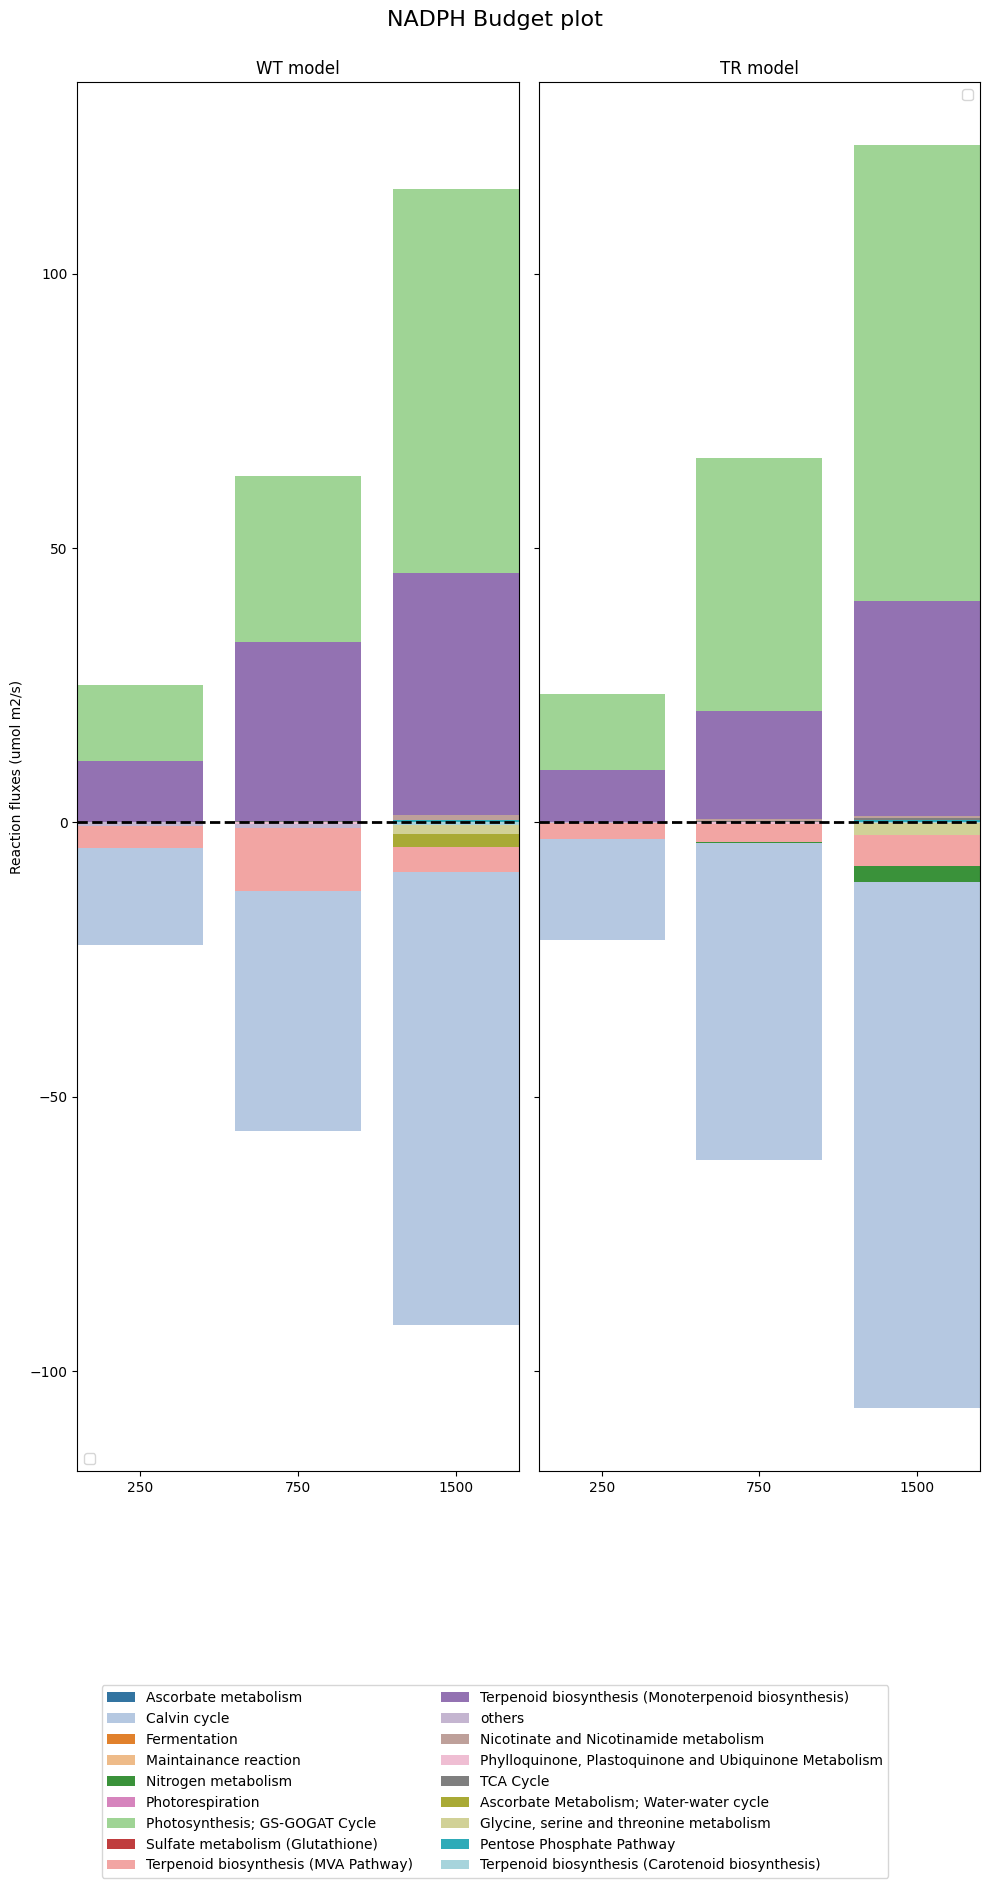

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)NADPH.png


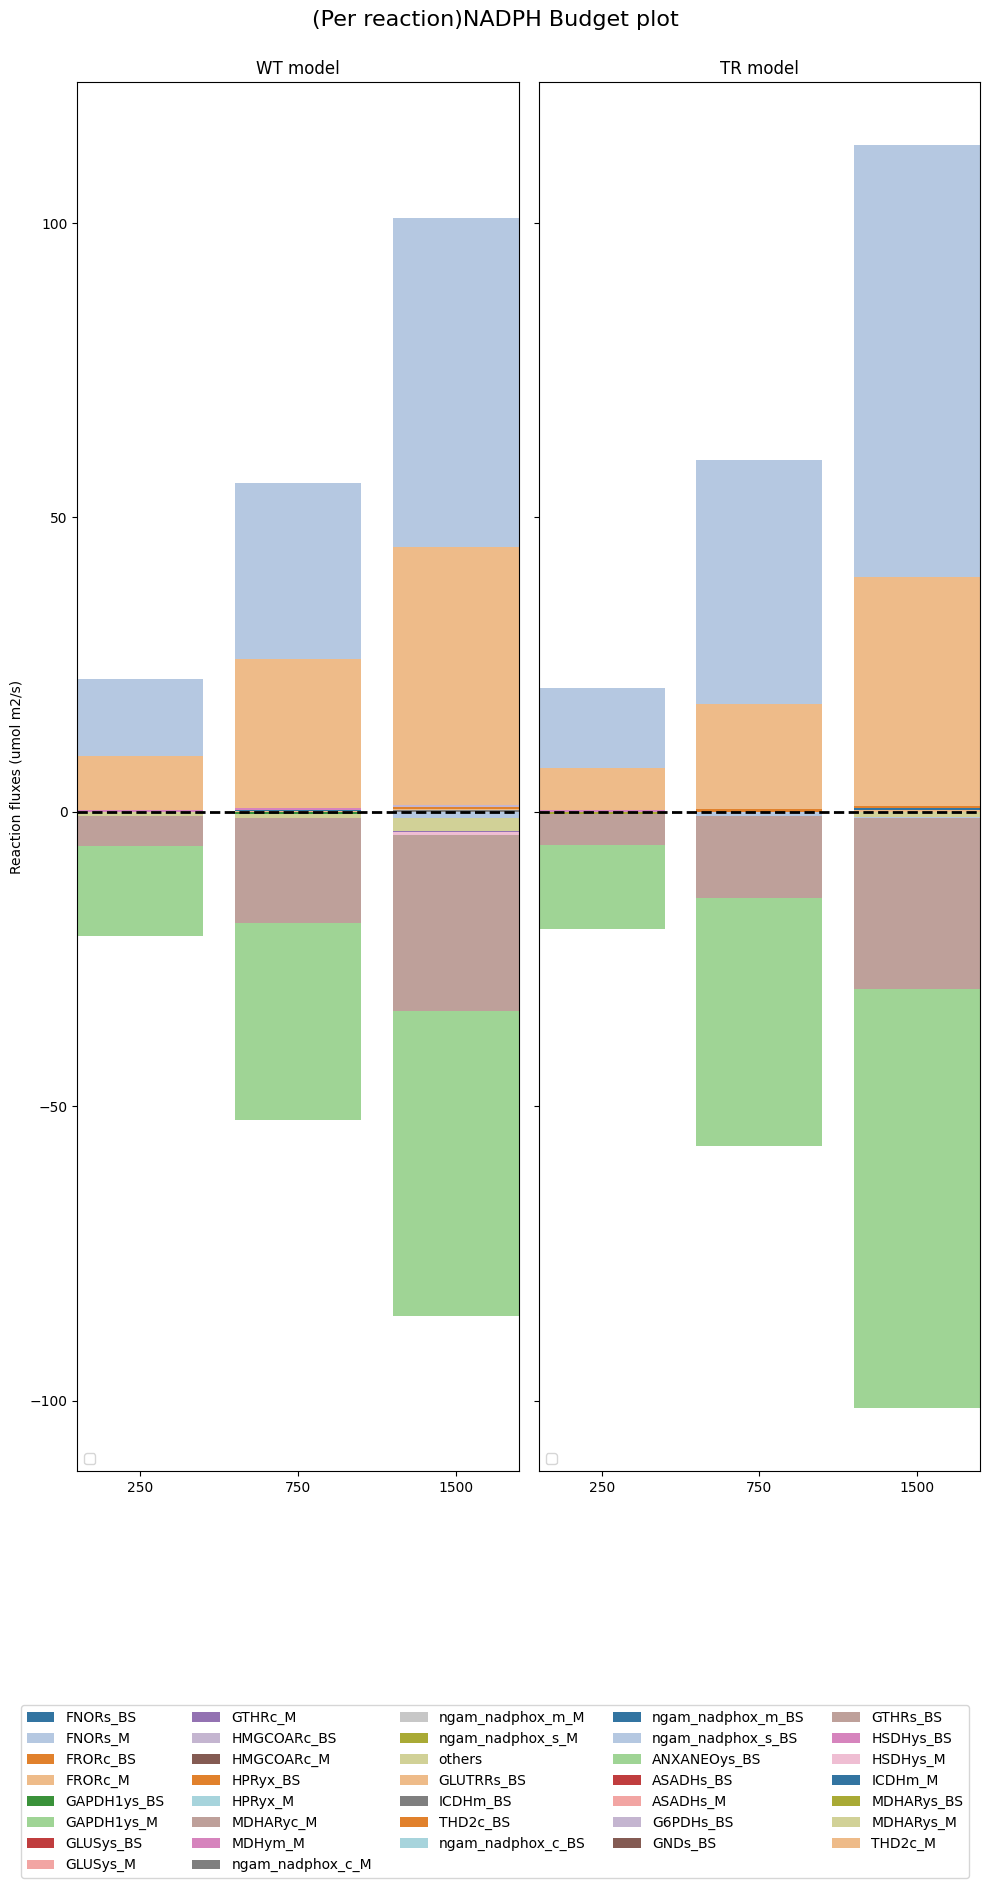

saved plot to ./plots/1510202/Budget_plotsATP.png


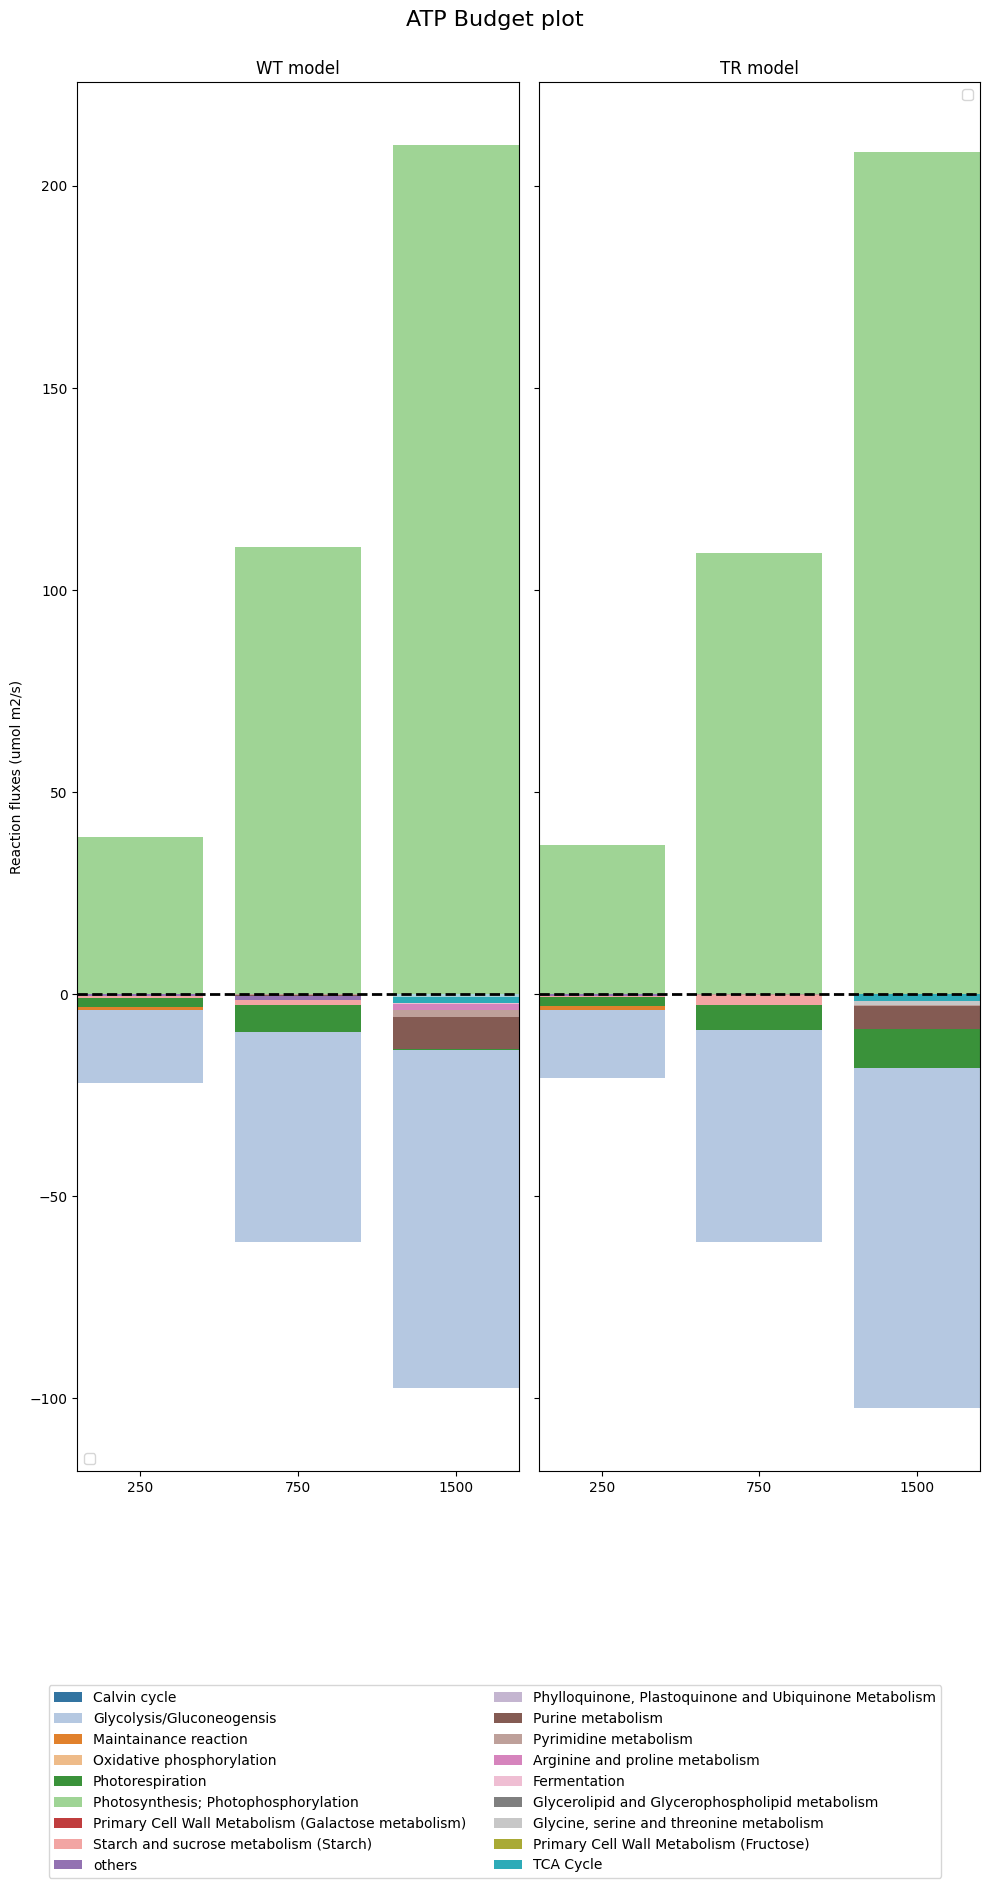

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)ATP.png


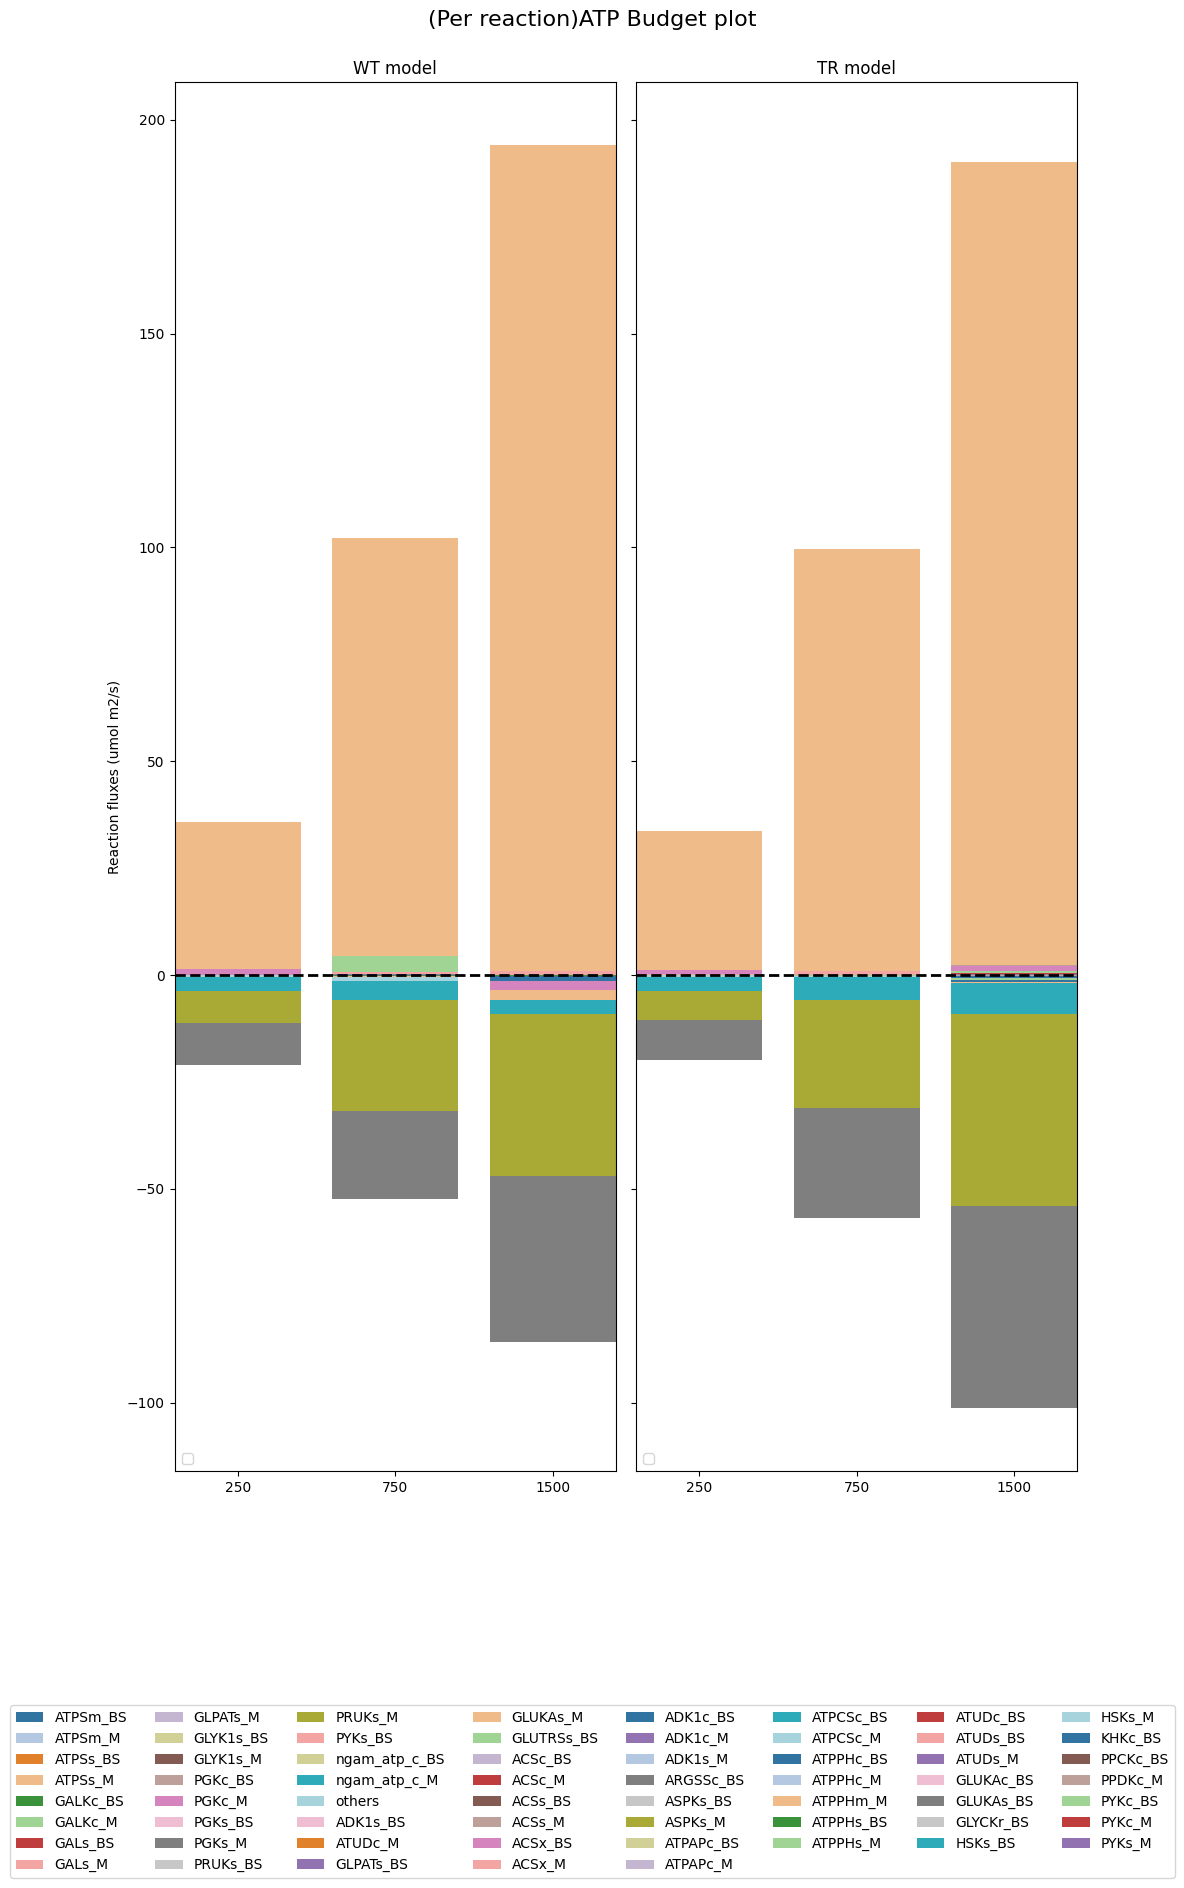

saved plot to ./plots/1510202/Budget_plotsNADH.png


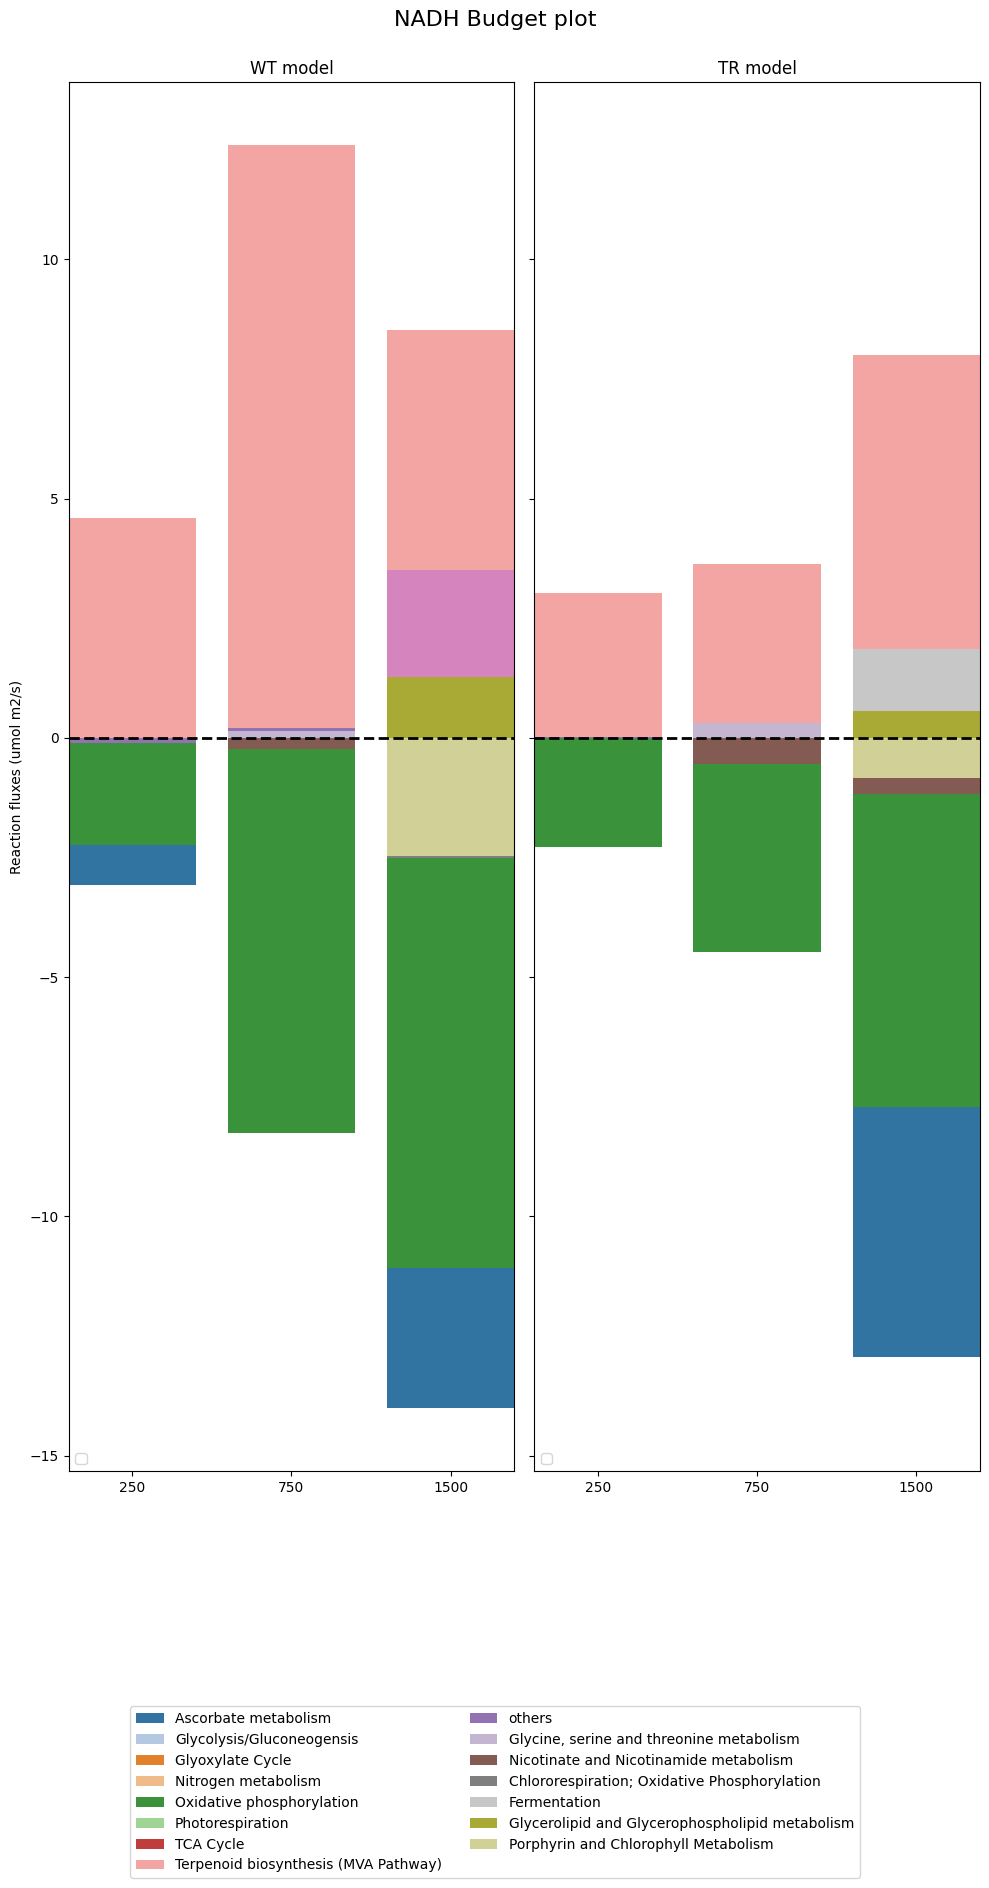

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)NADH.png


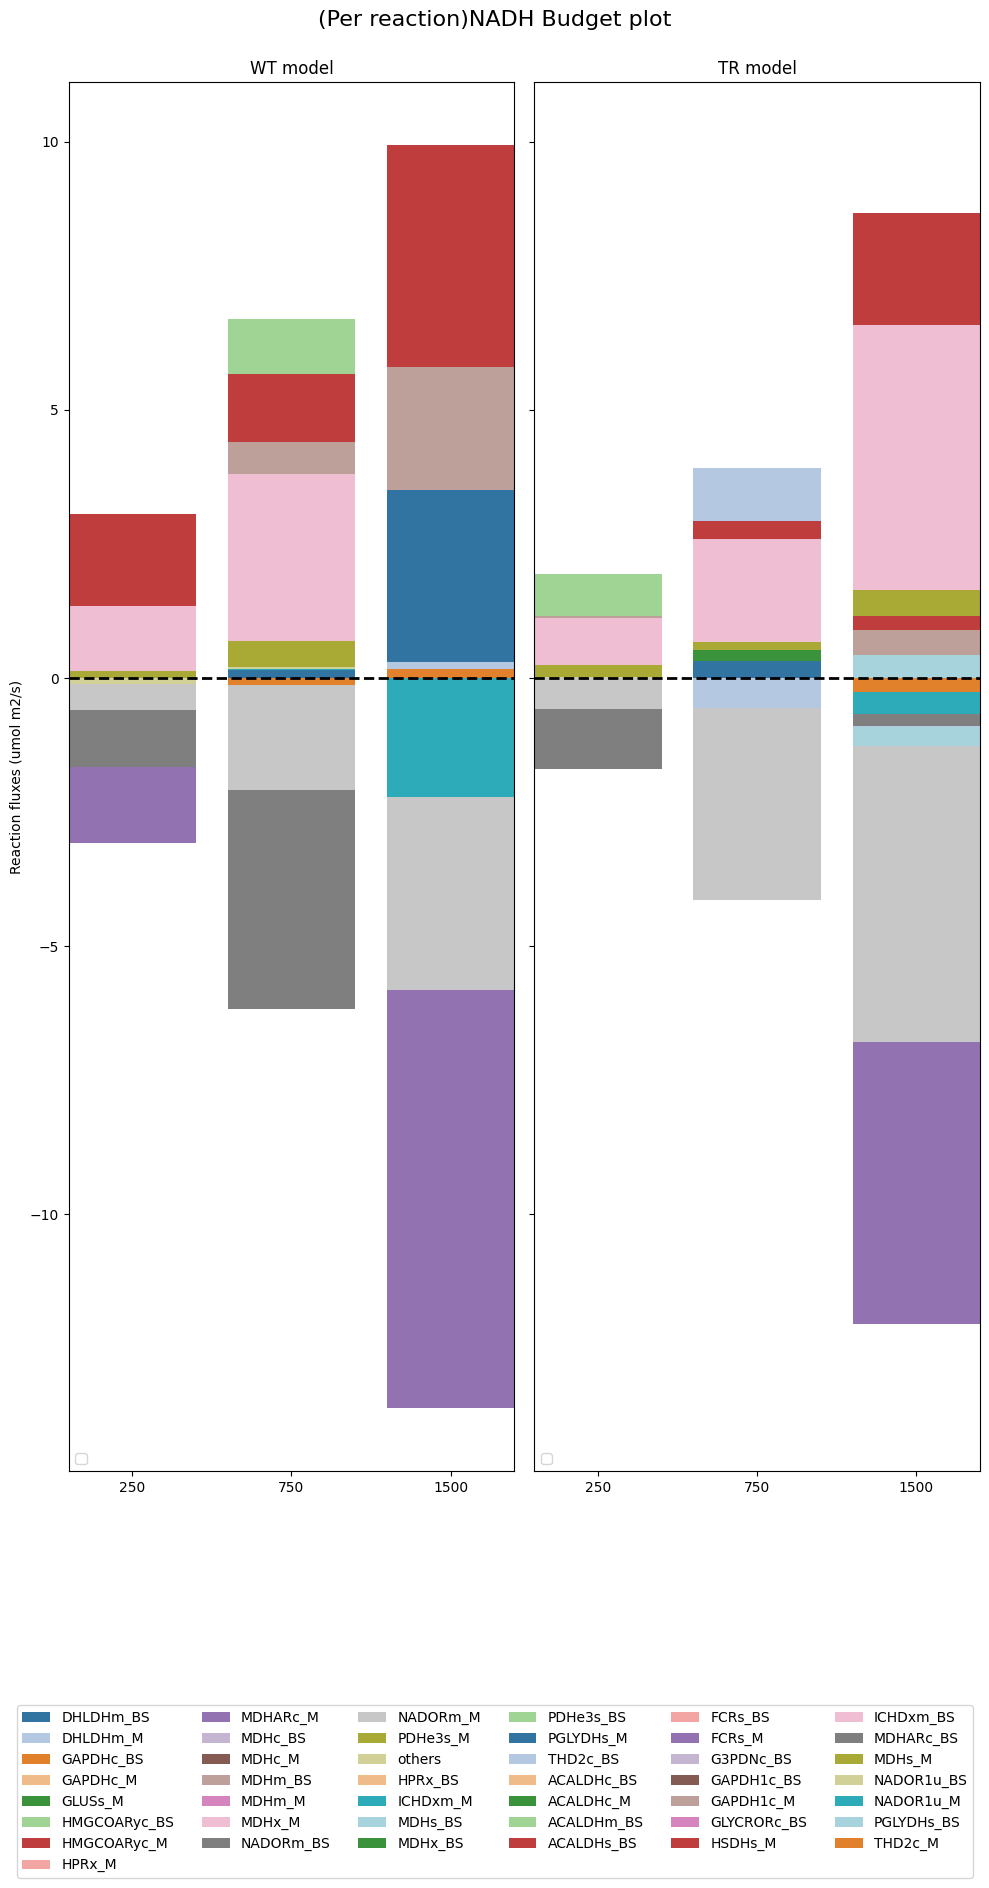

saved plot to ./plots/1510202/Budget_plotsL-malate.png


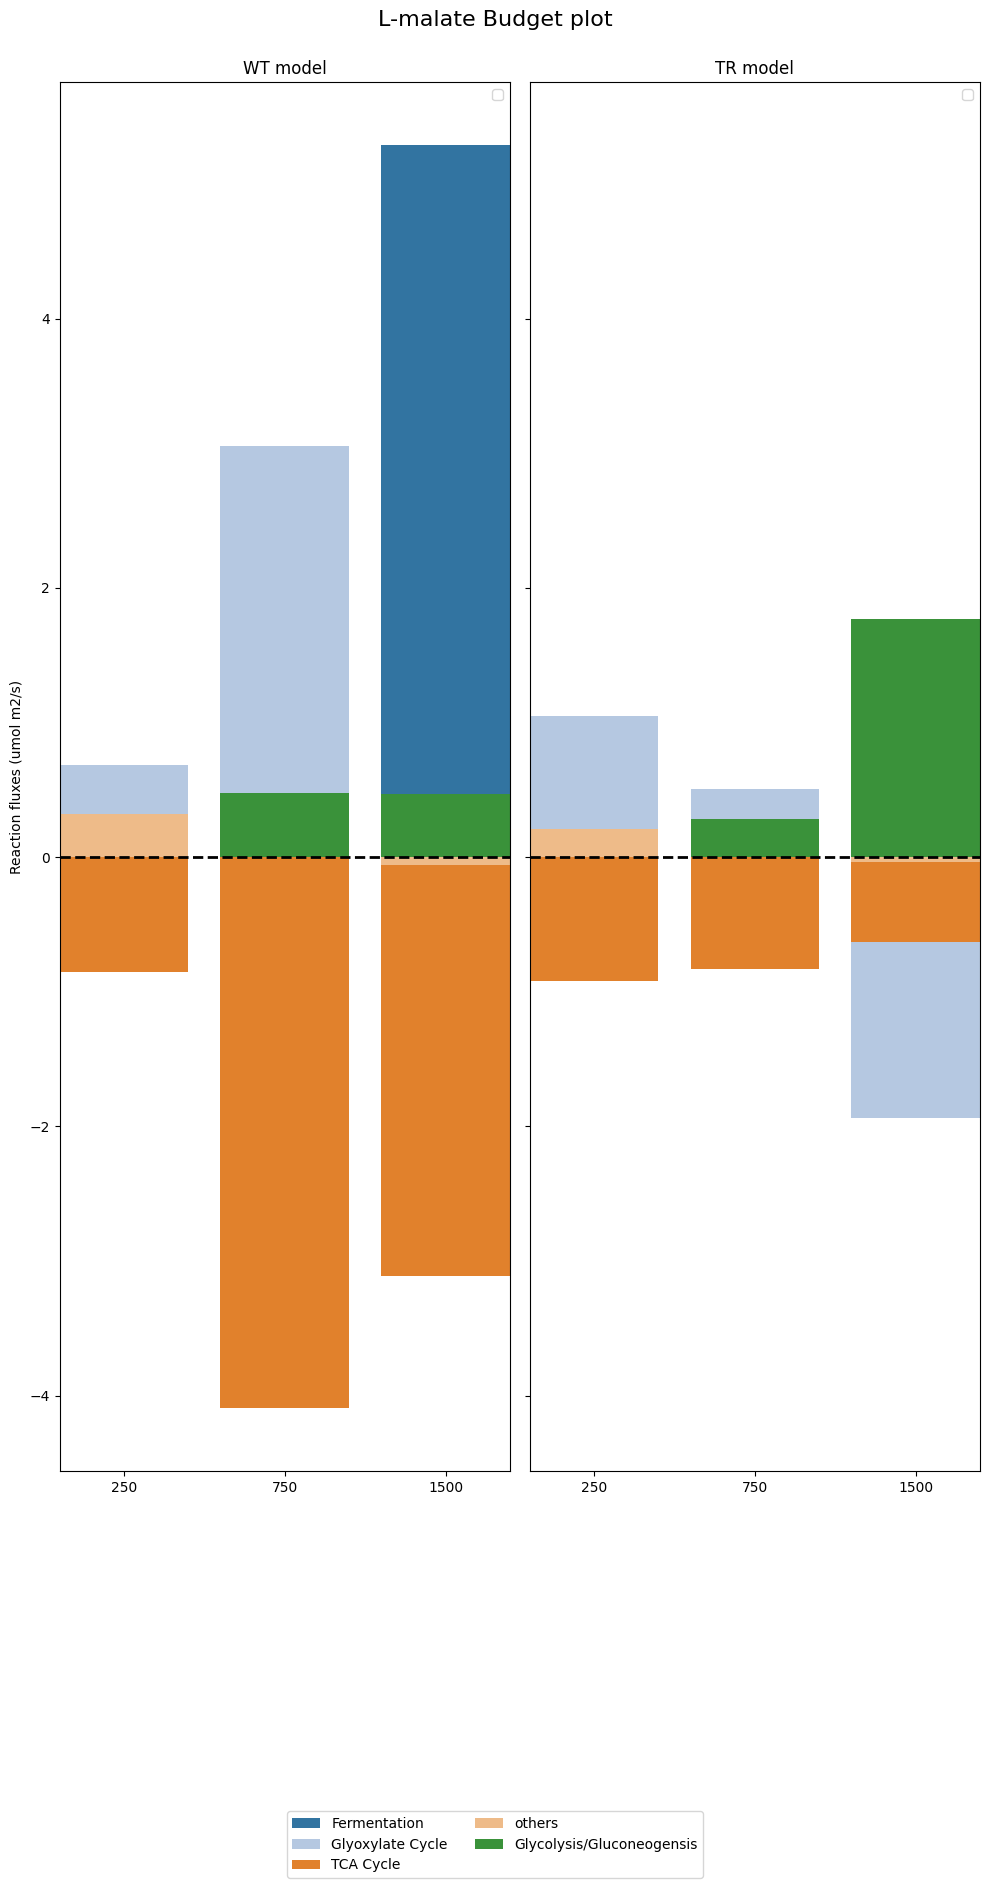

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)L-malate.png


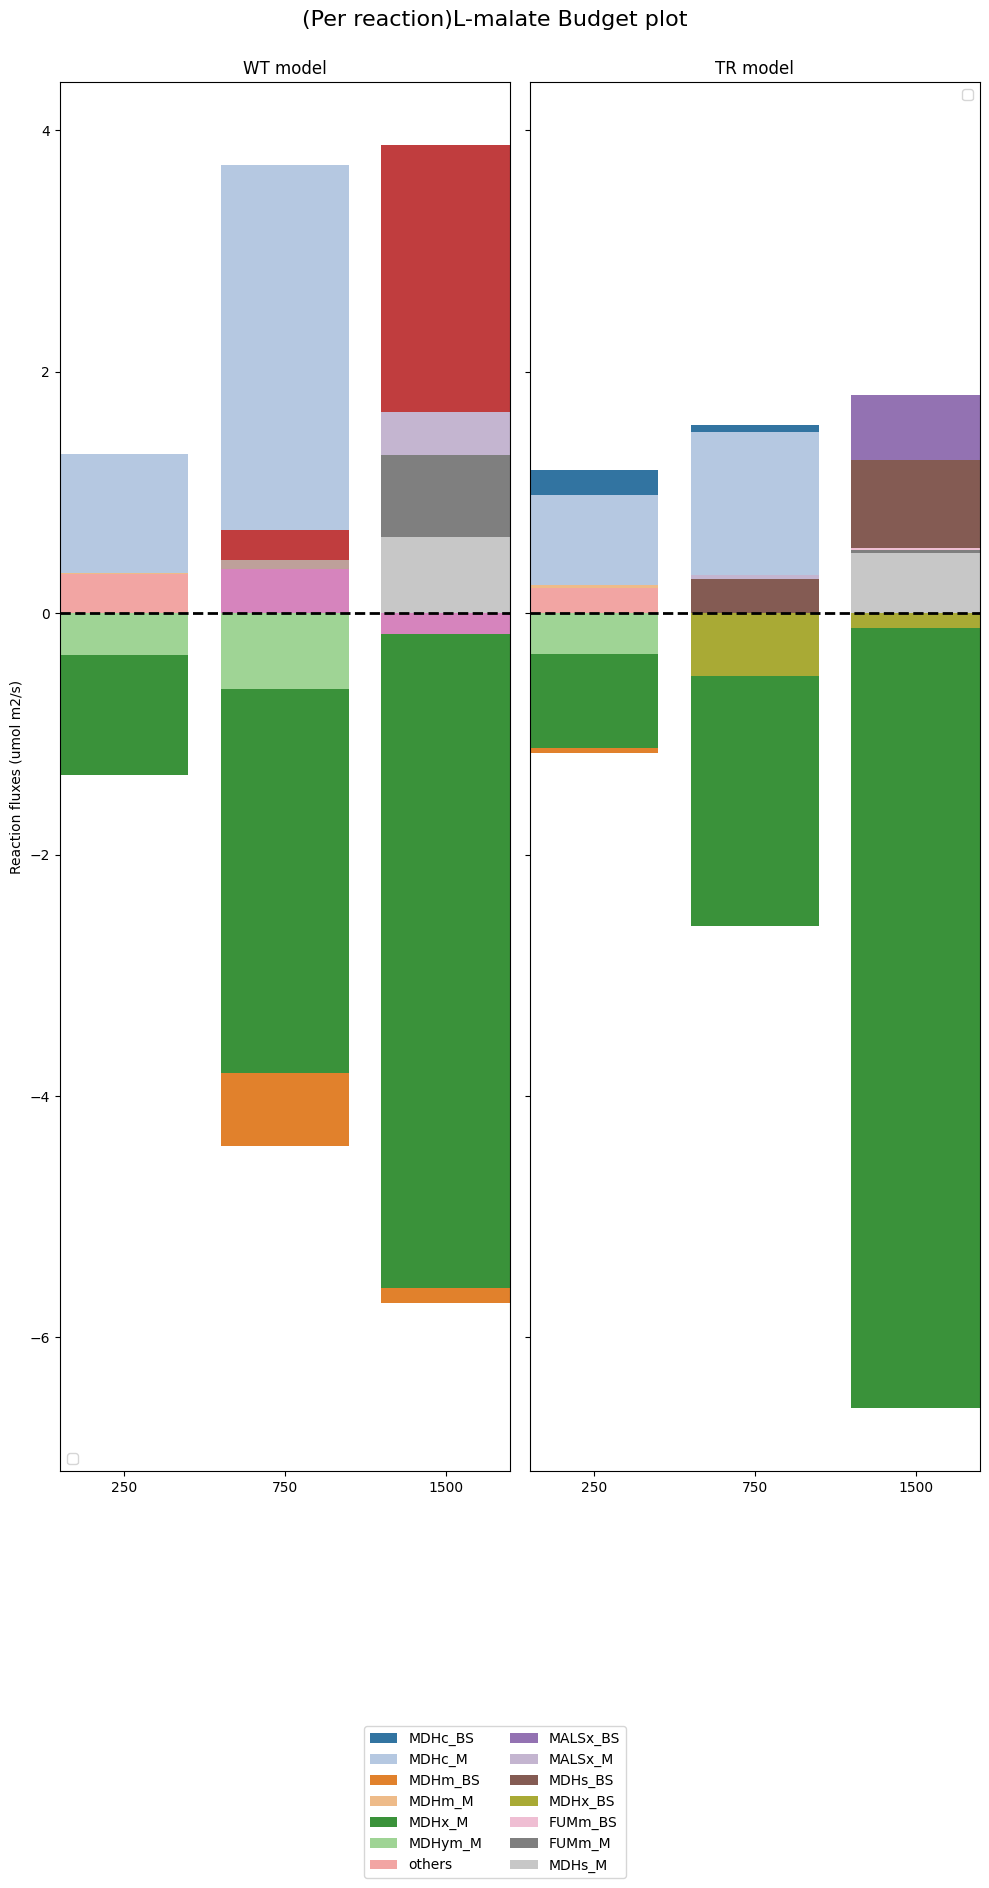

saved plot to ./plots/1510202/Budget_plotsCO2.png


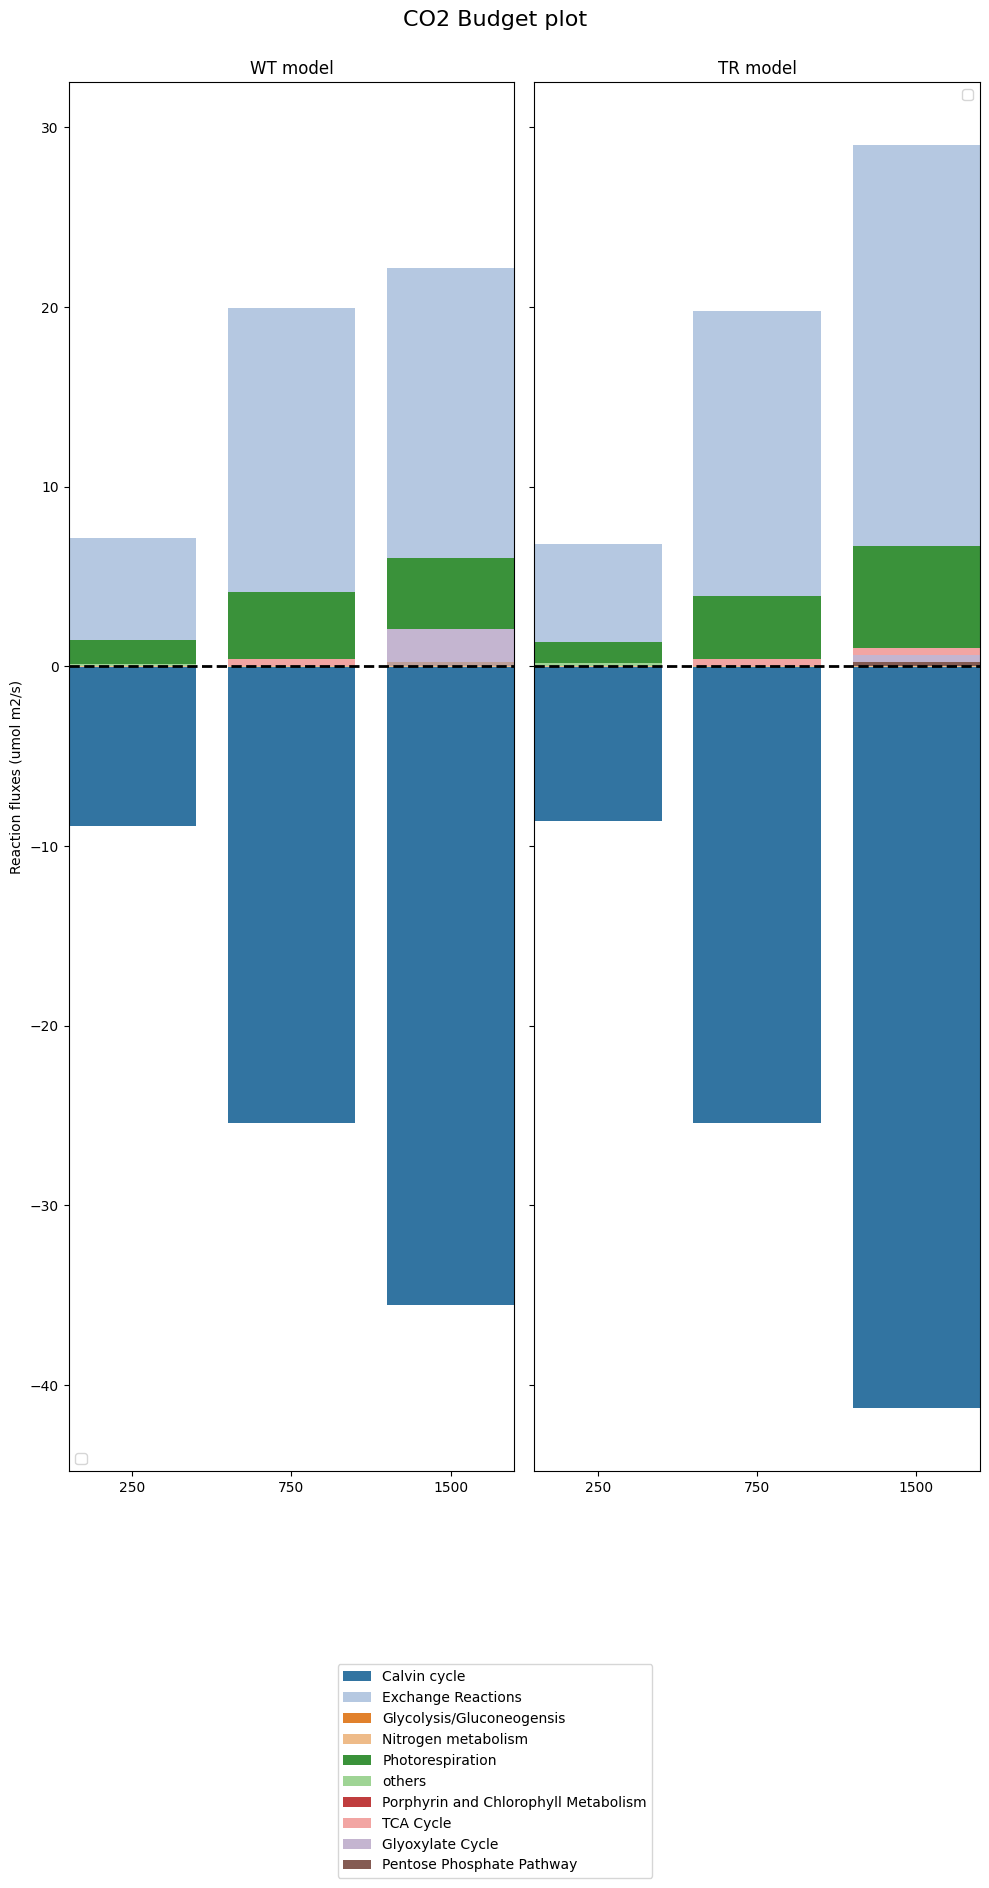

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)CO2.png


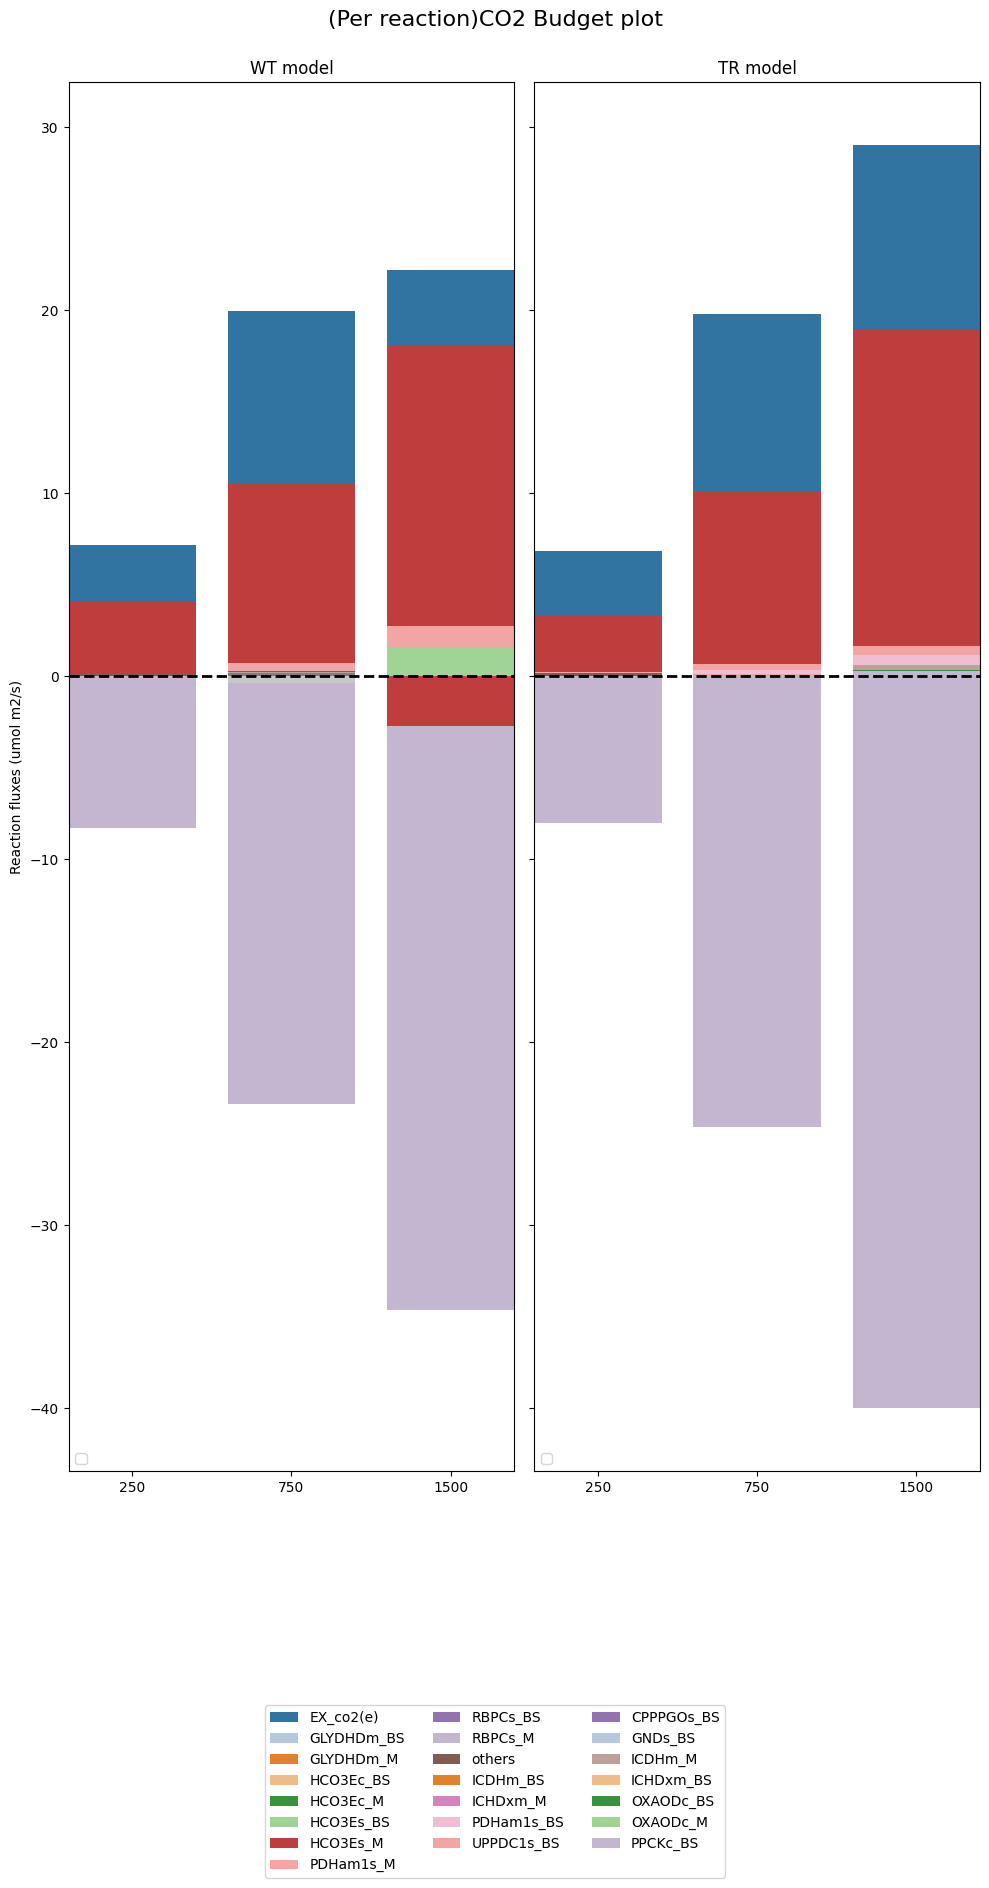

saved plot to ./plots/1510202/Budget_plotsO2.png


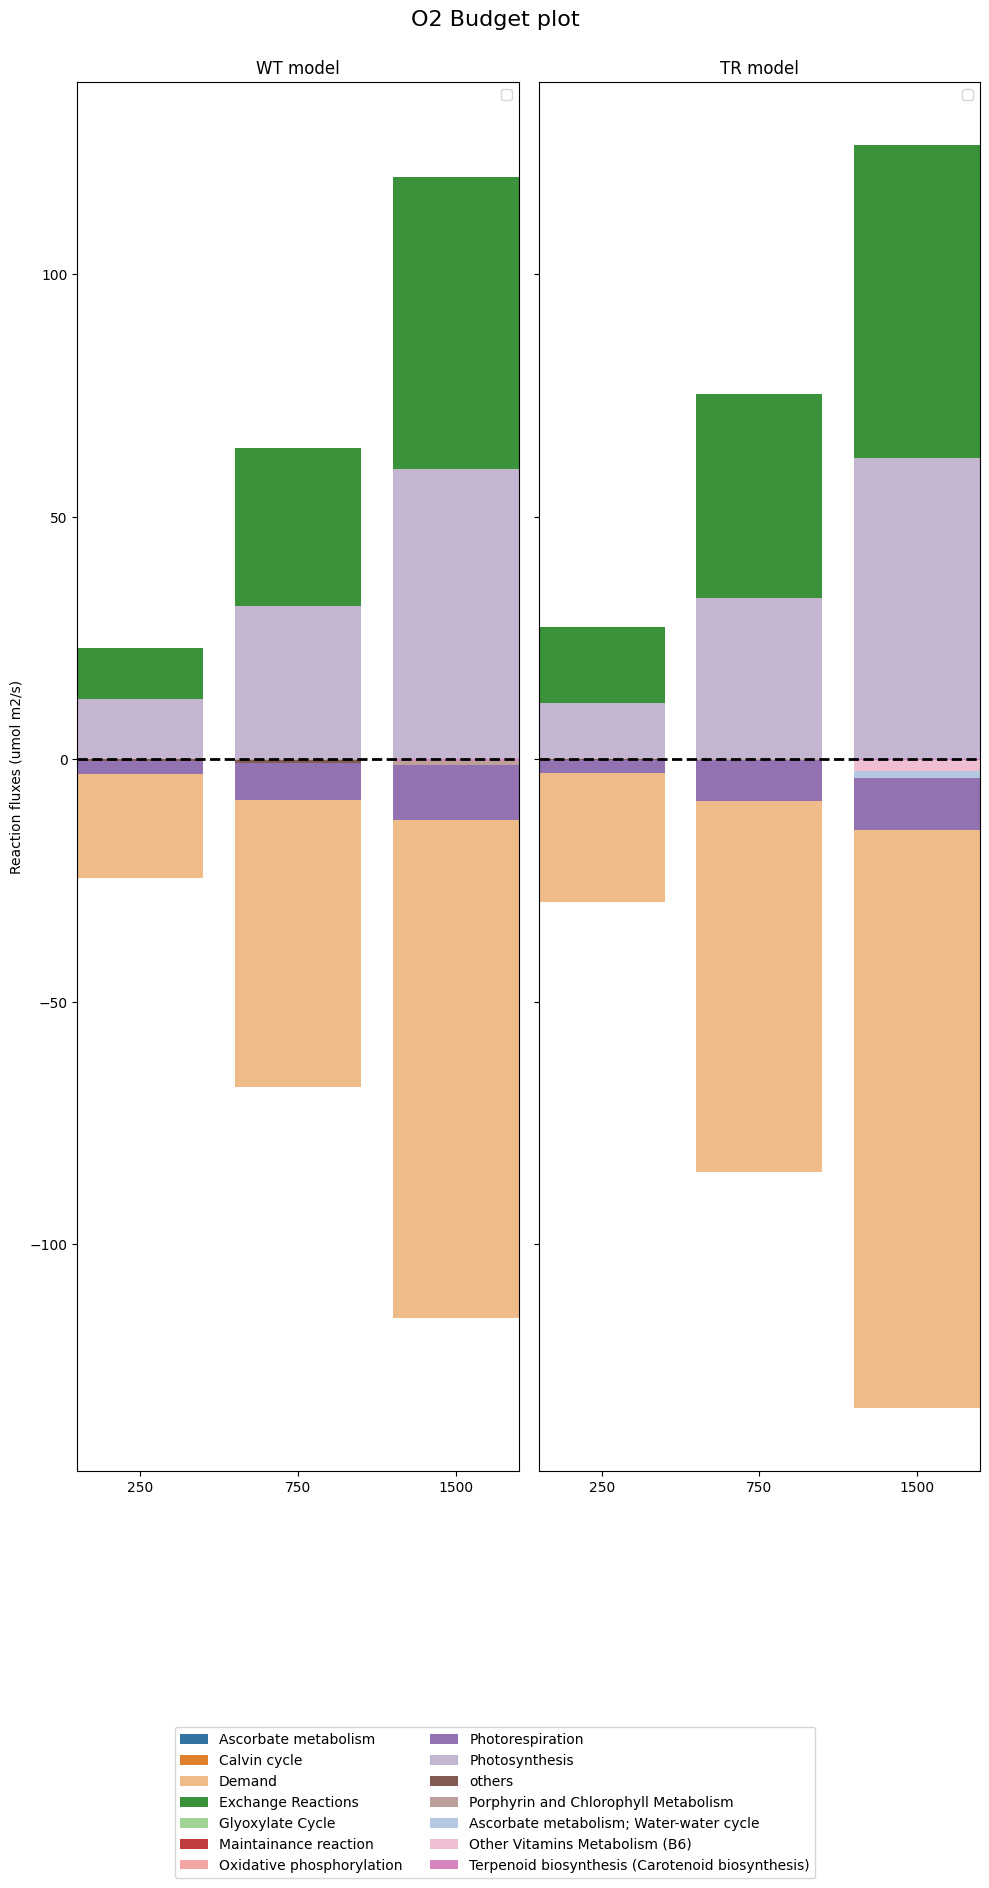

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)O2.png


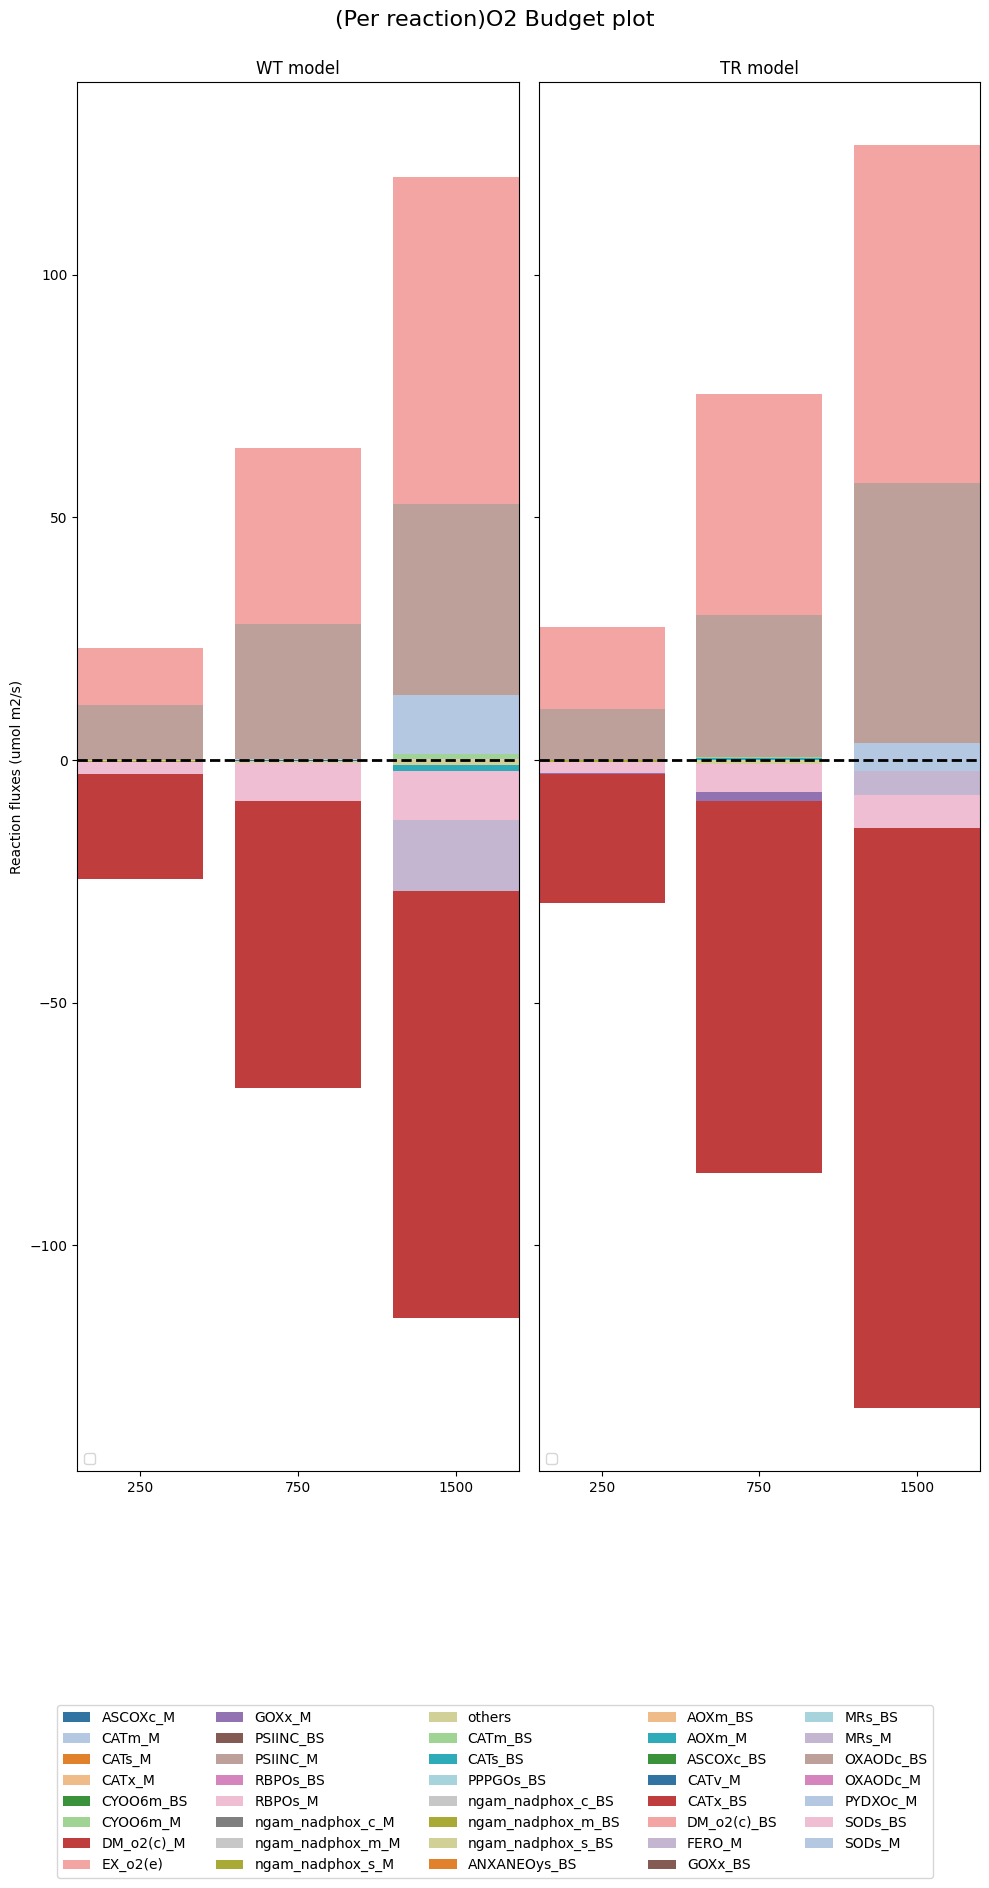

saved plot to ./plots/1510202/Budget_plotsDHAP.png


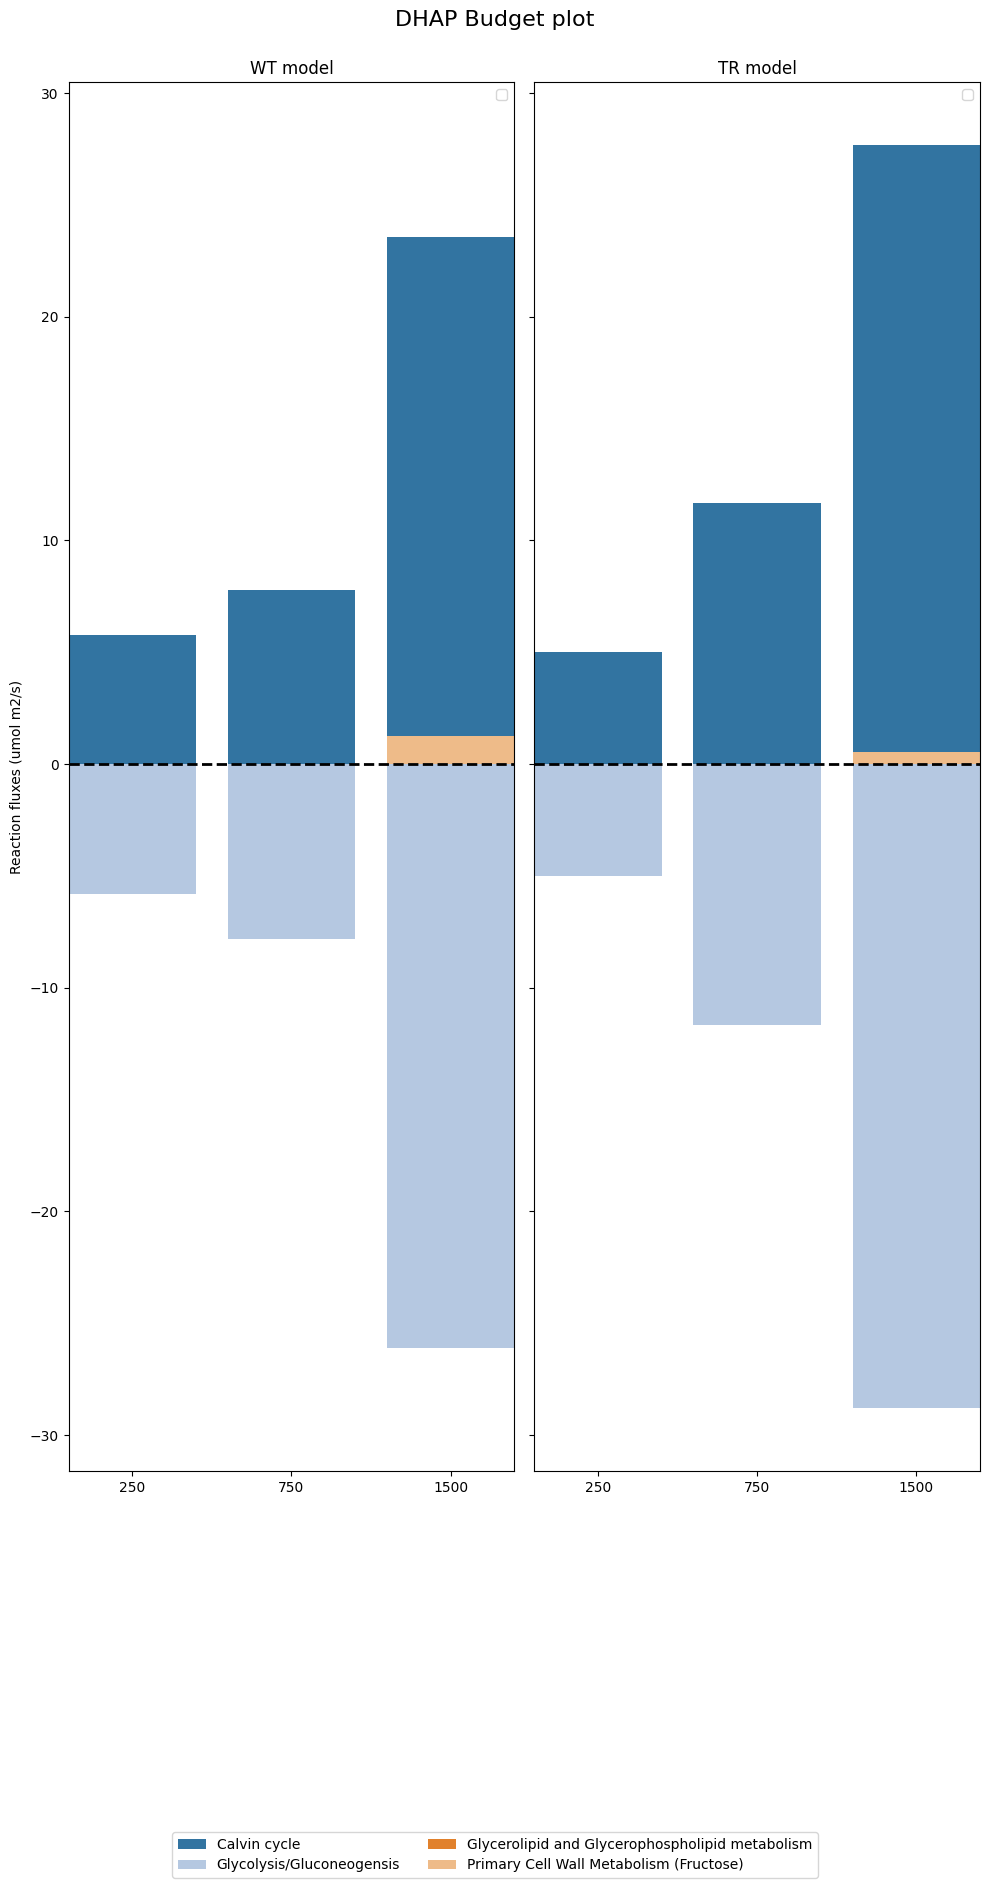

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)DHAP.png


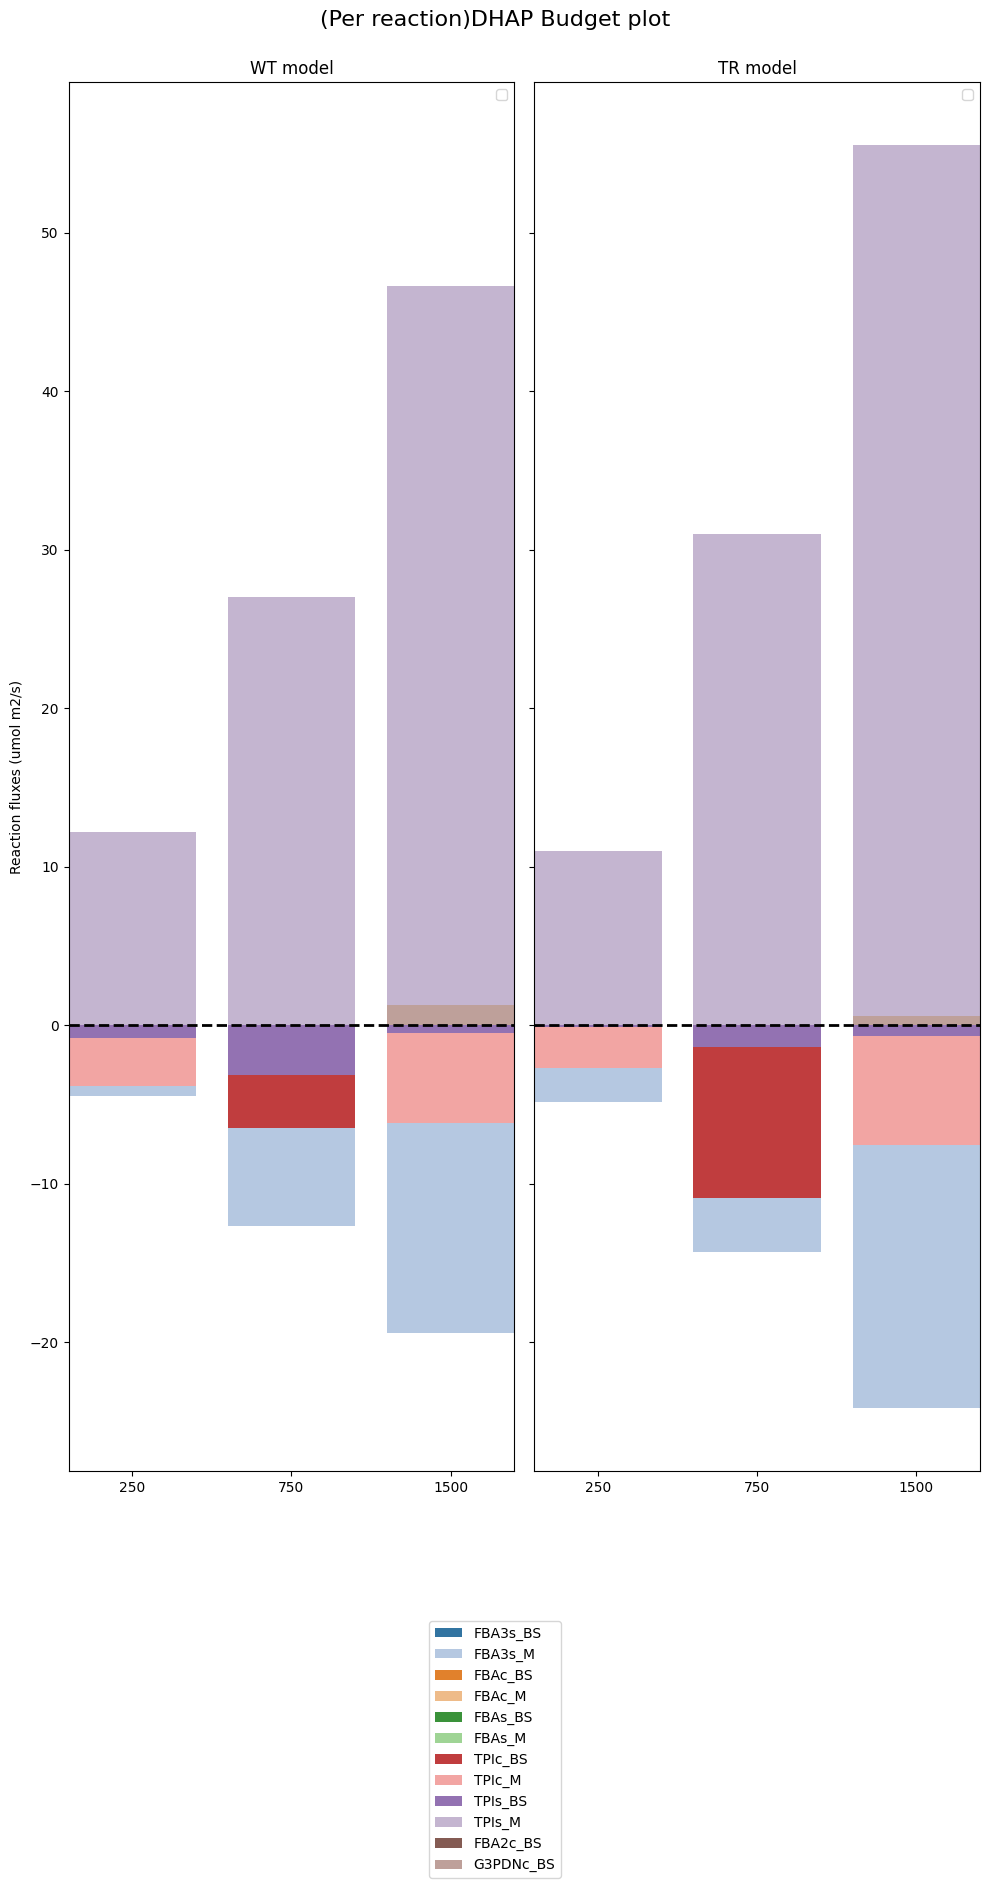

saved plot to ./plots/1510202/Budget_plotsH2O.png


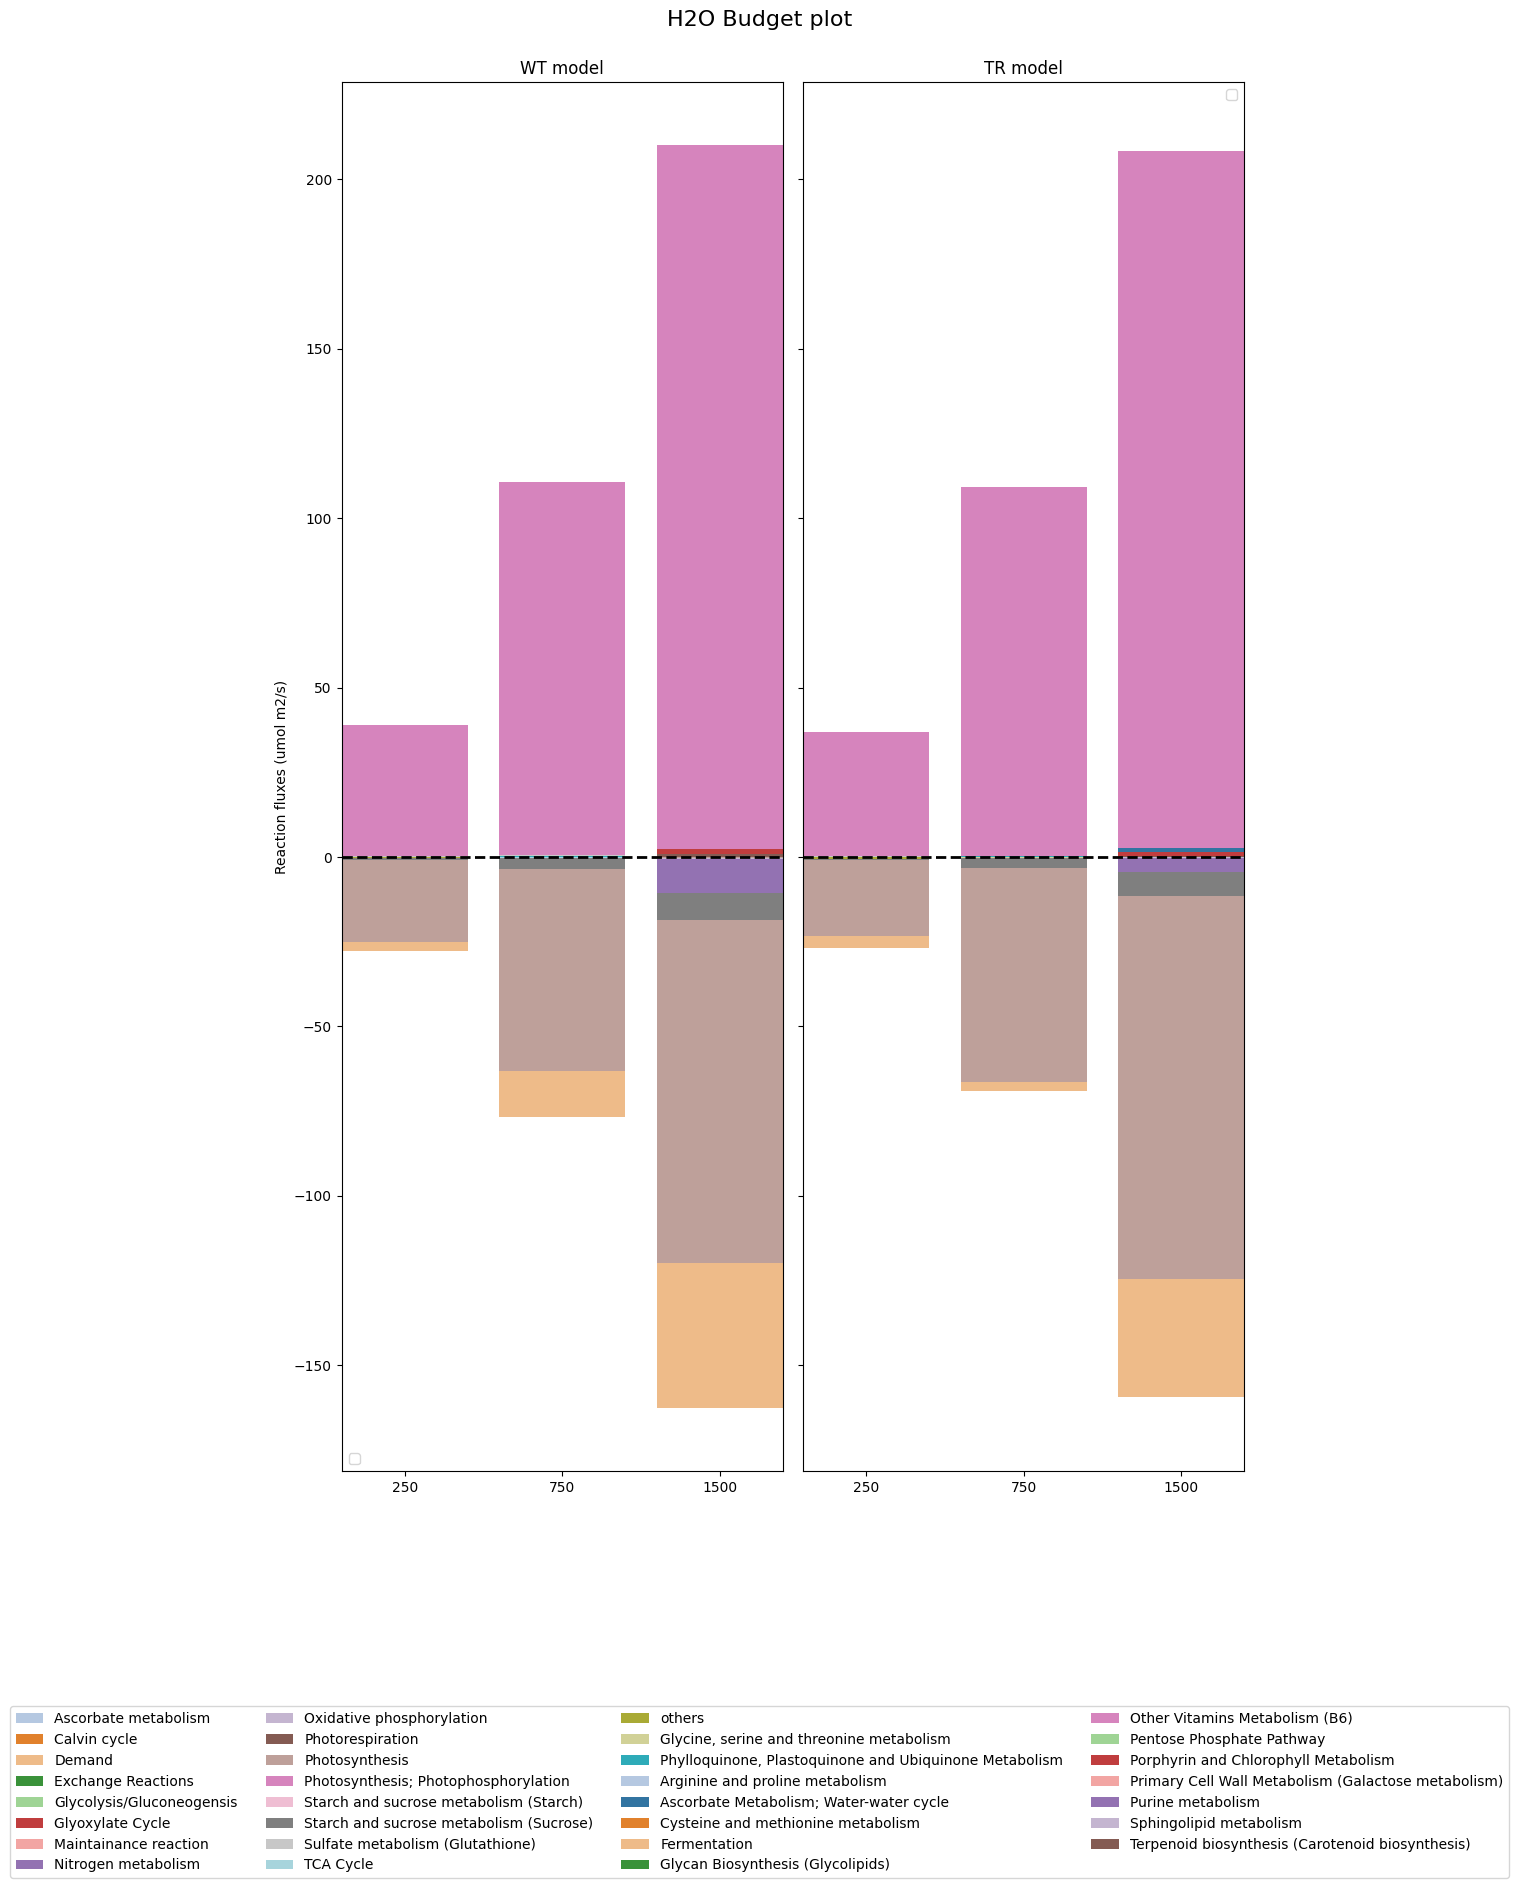

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)H2O.png


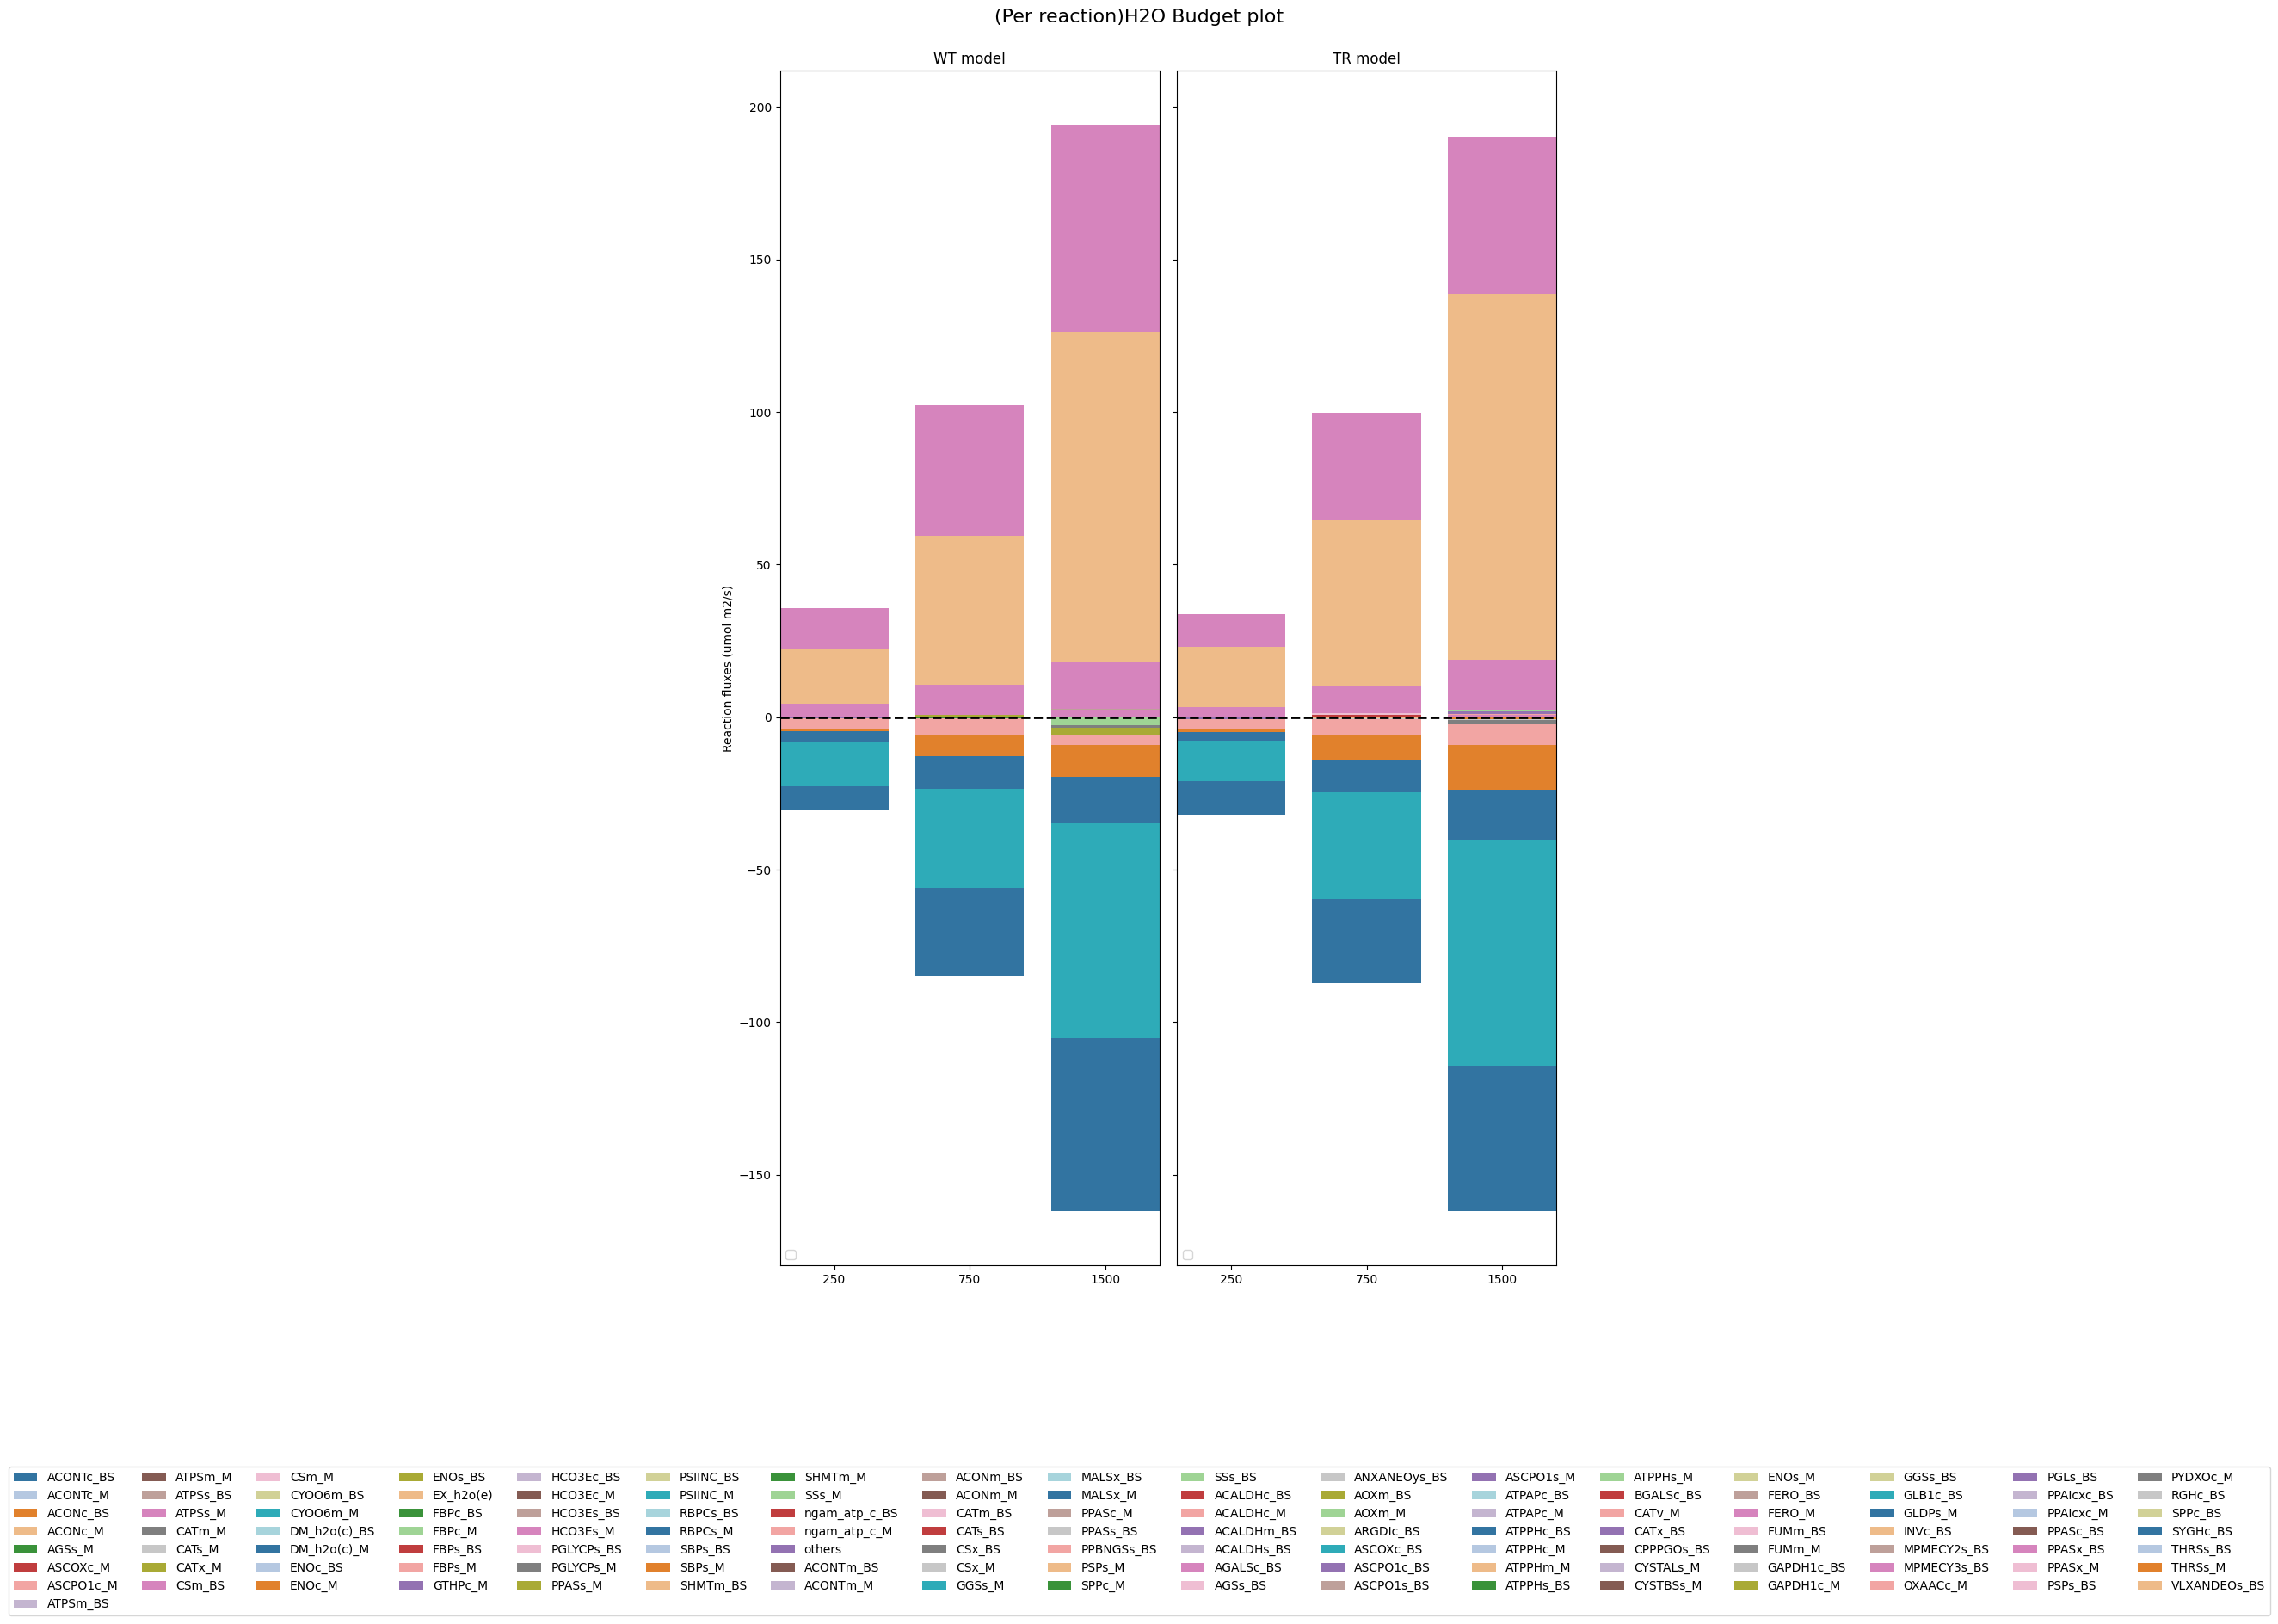

saved plot to ./plots/1510202/Budget_plotsNH4.png


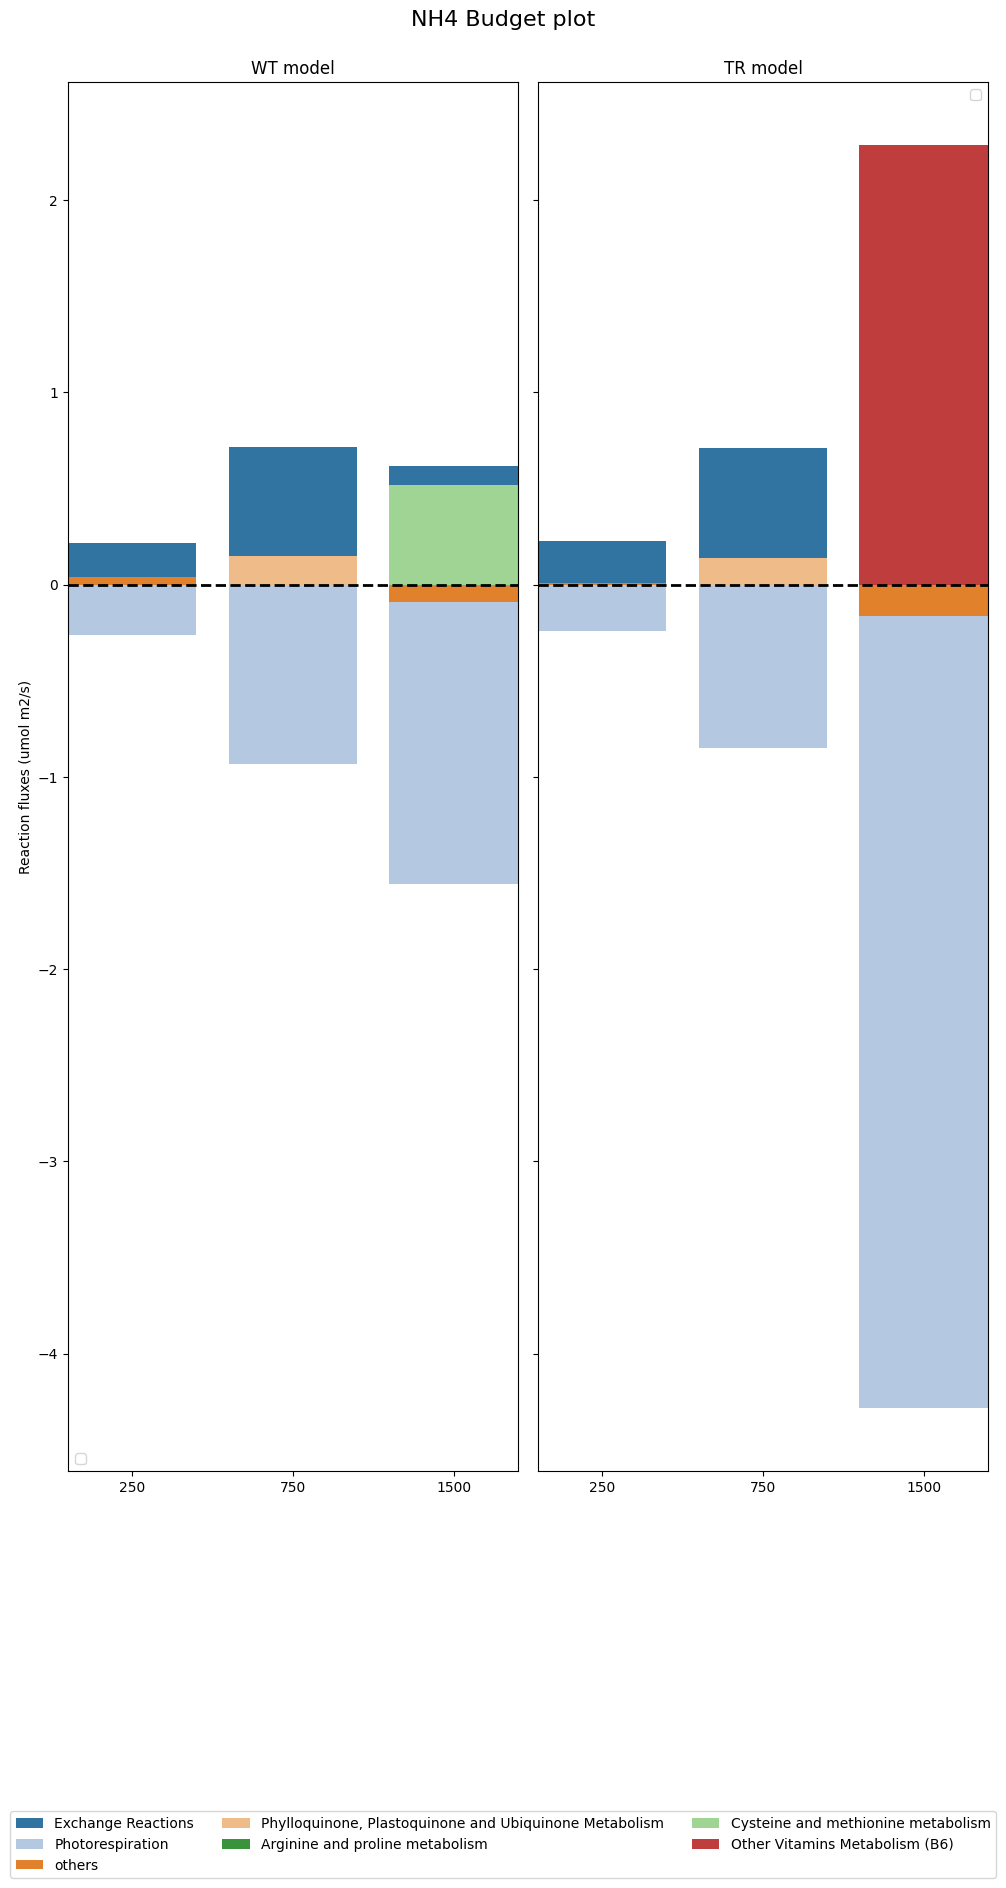

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)NH4.png


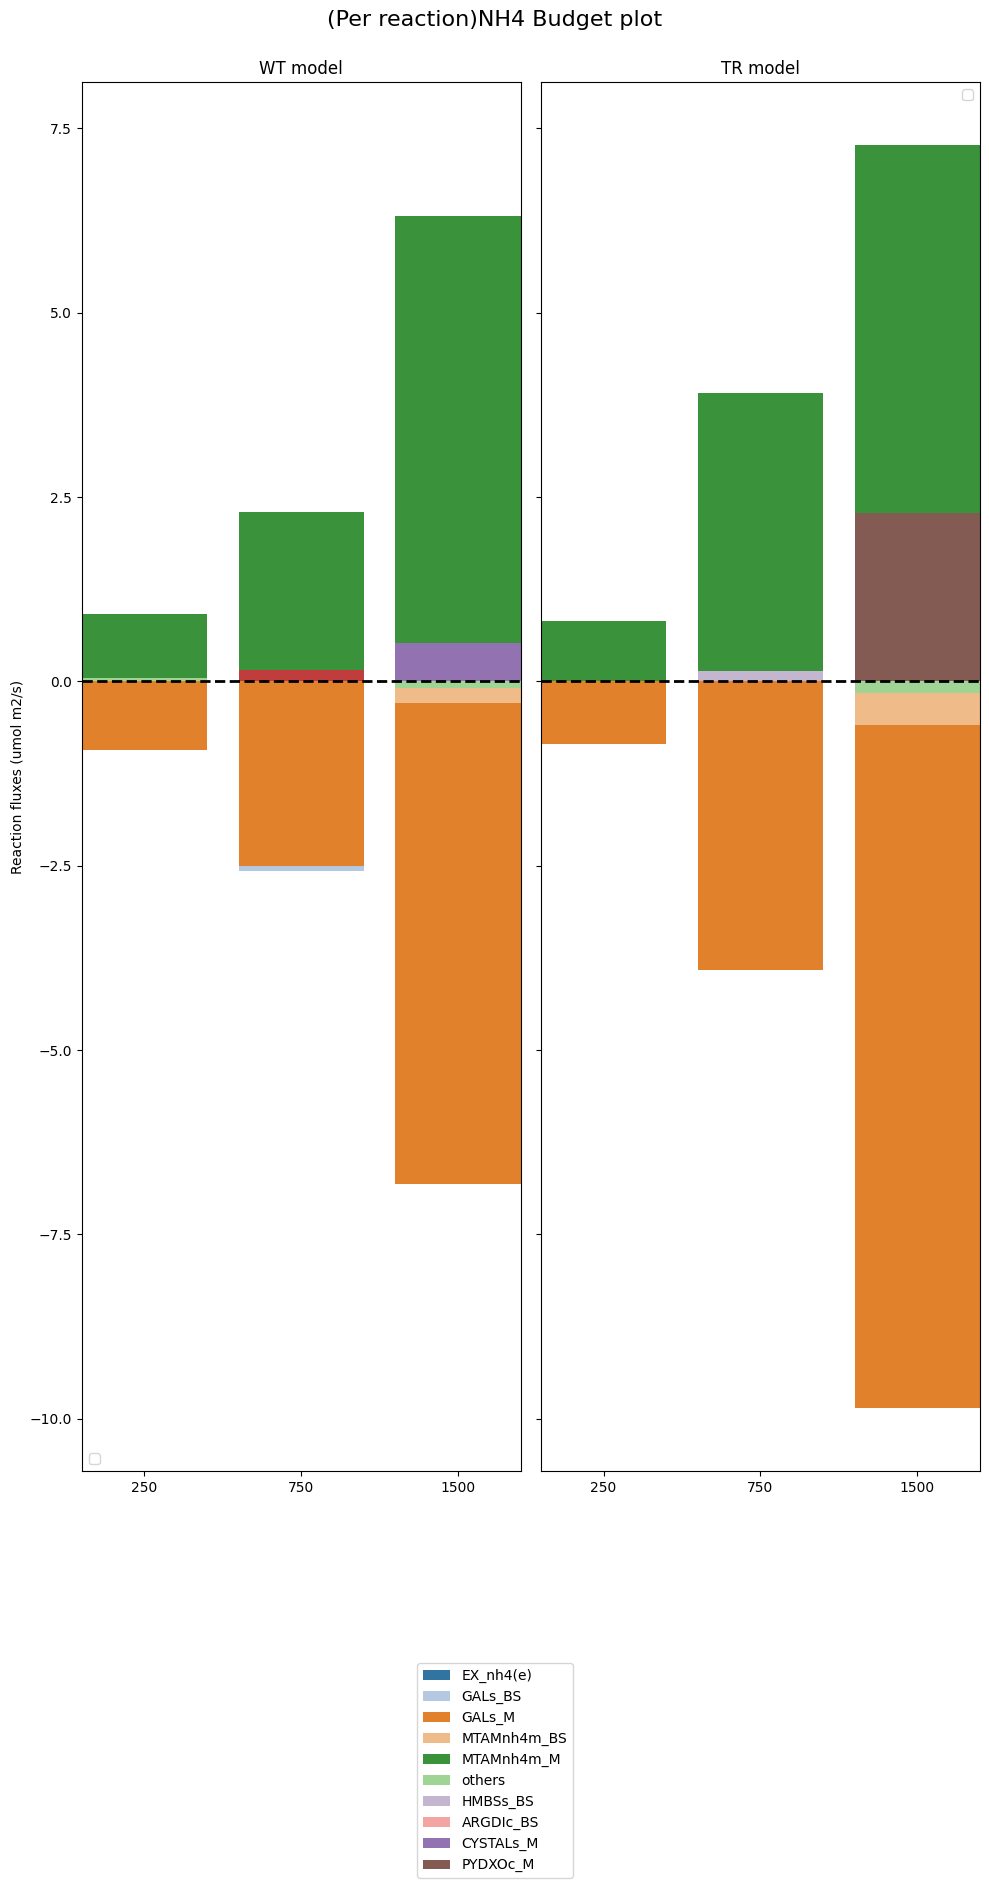

saved plot to ./plots/1510202/Budget_plotsNADPH (Stromal M).png


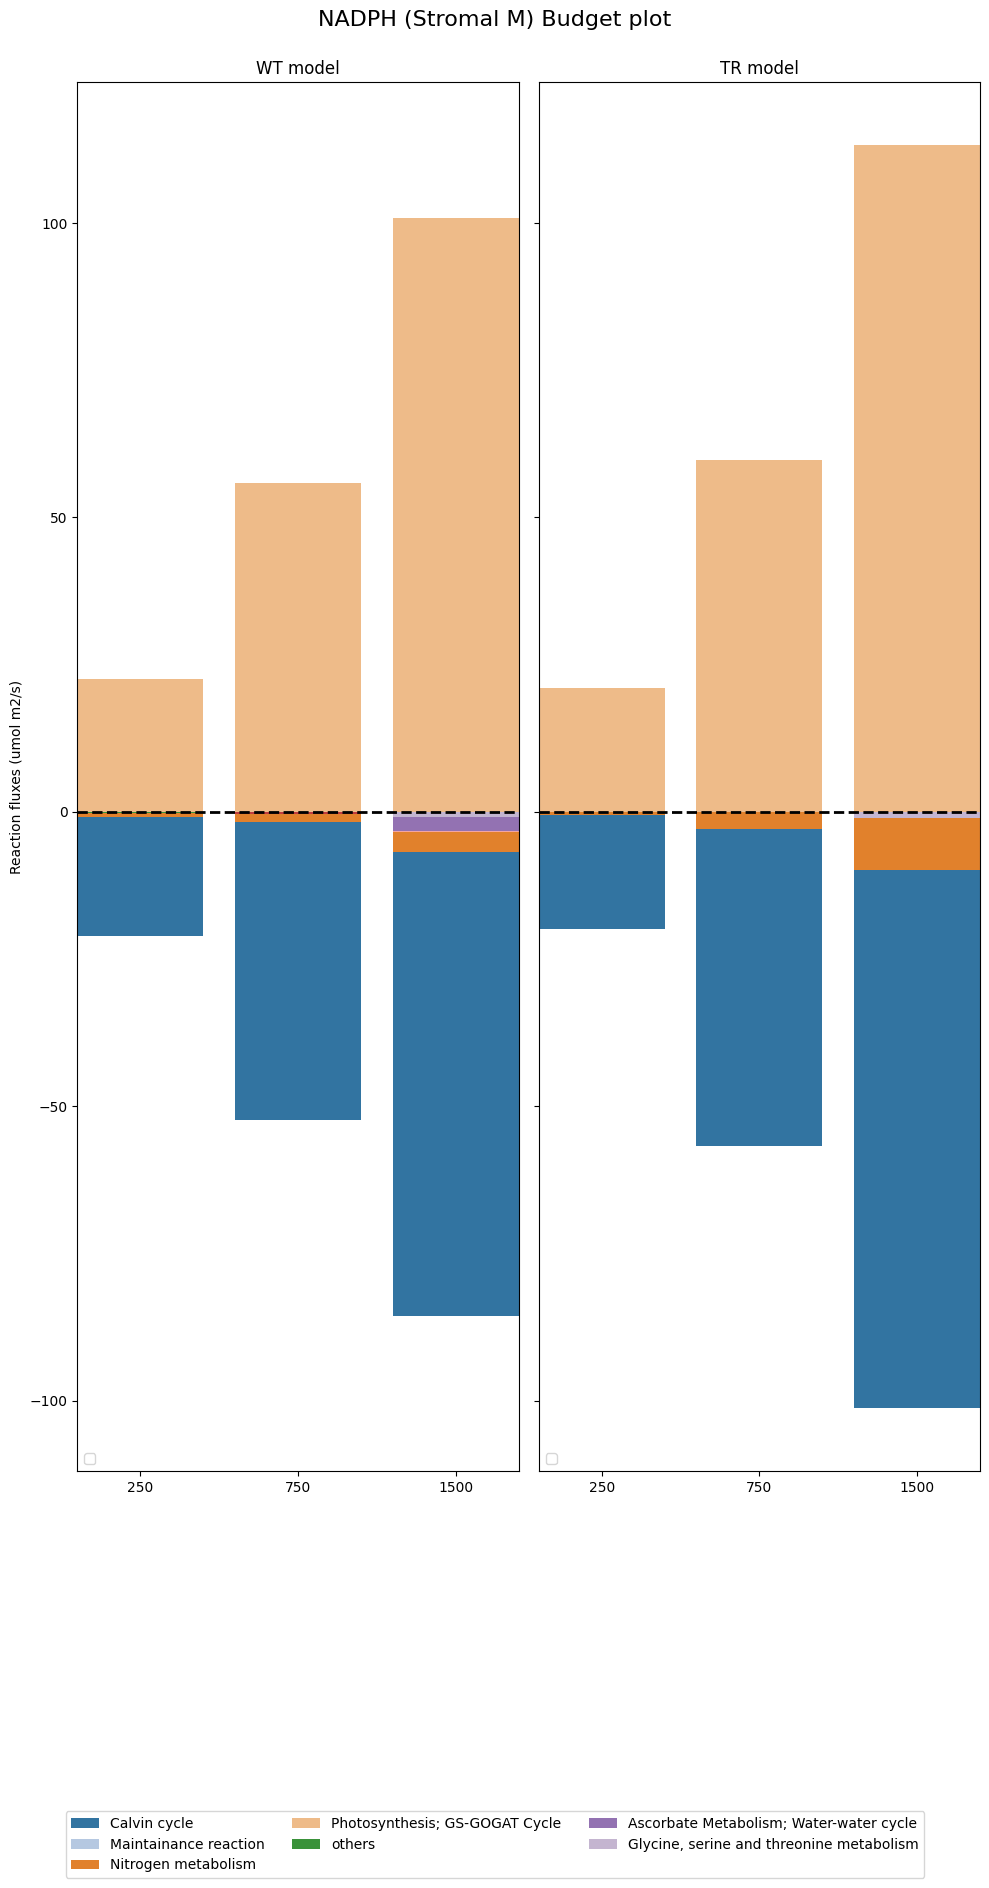

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)NADPH (Stromal M).png


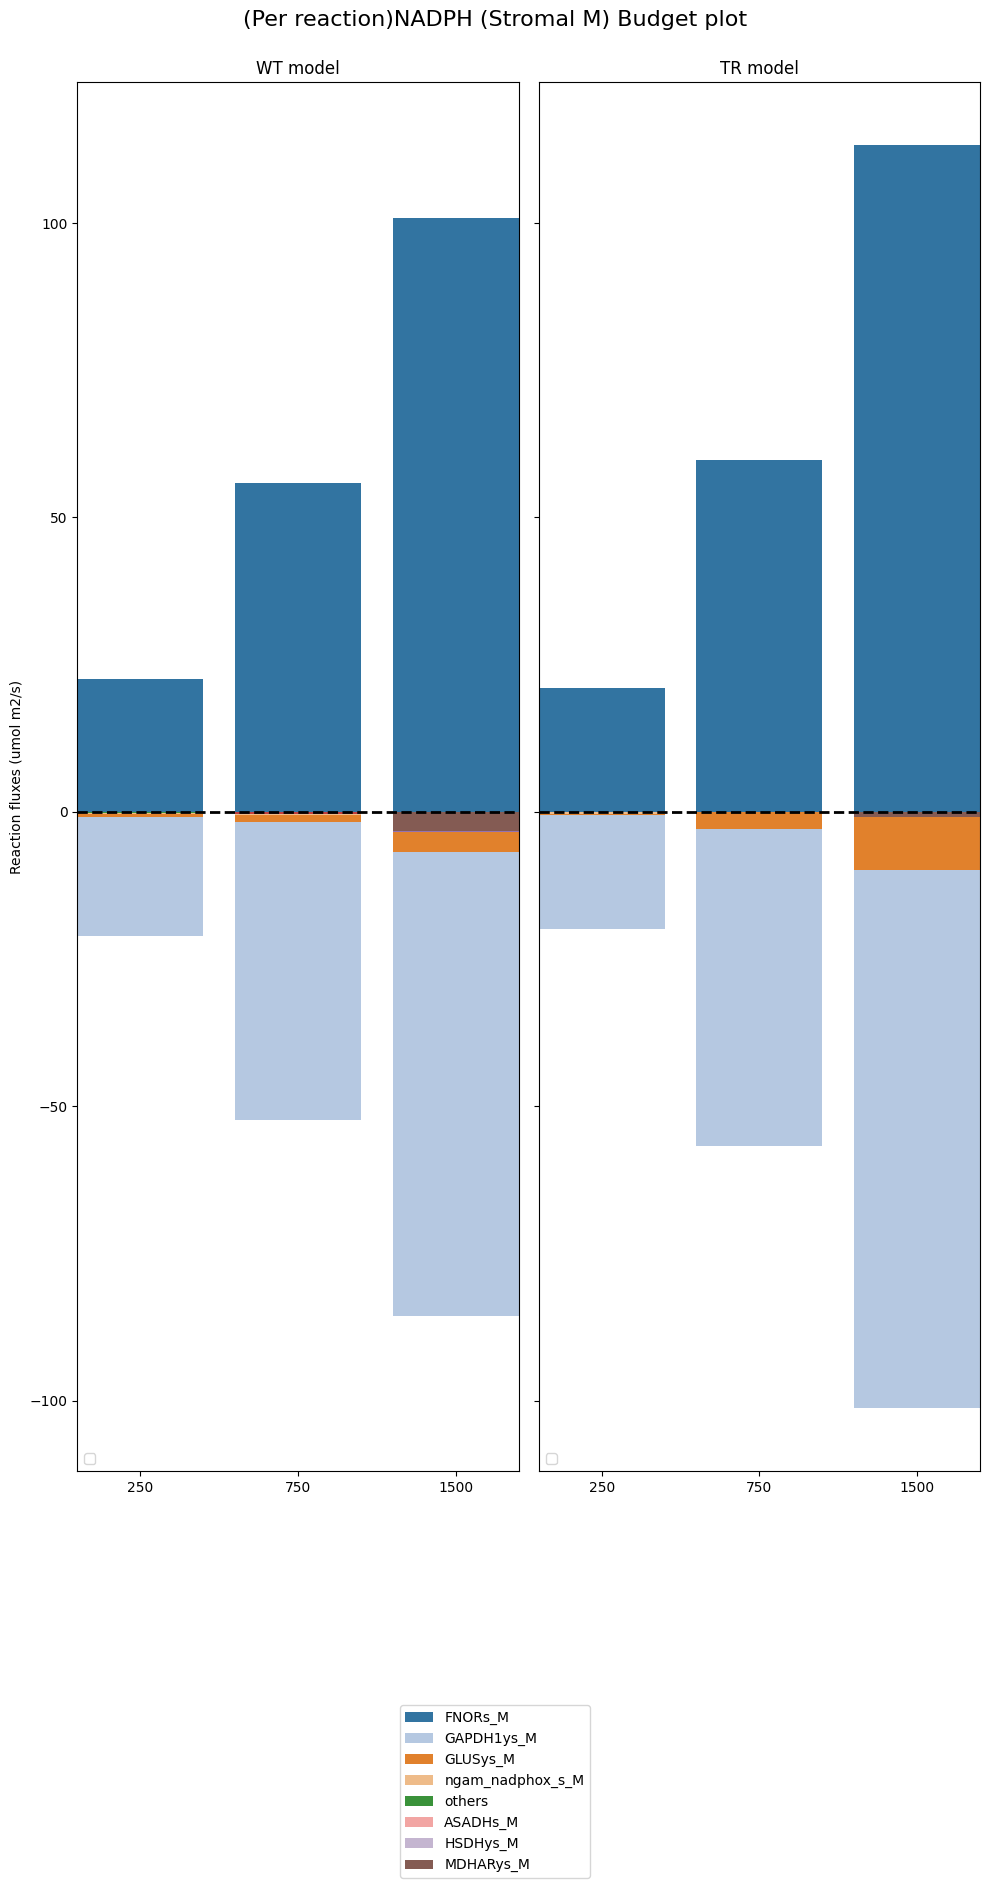

saved plot to ./plots/1510202/Budget_plotsATP (Cytosol M).png


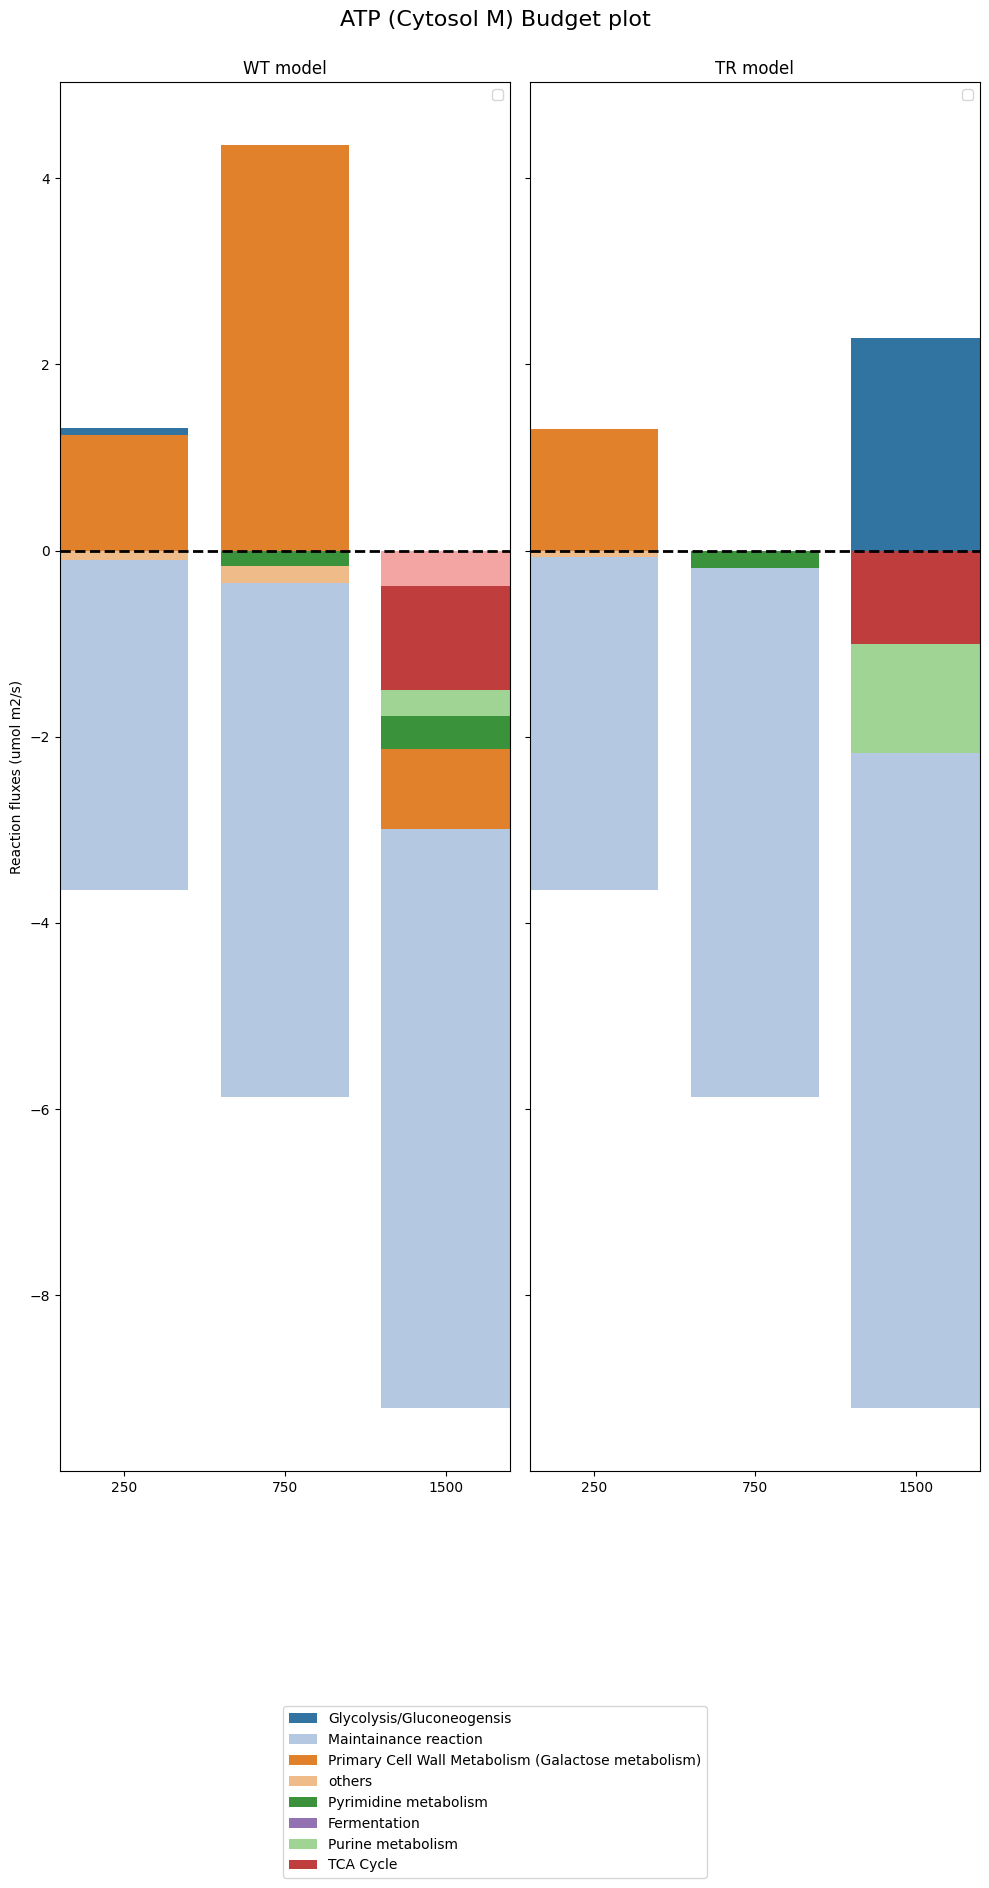

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)ATP (Cytosol M).png


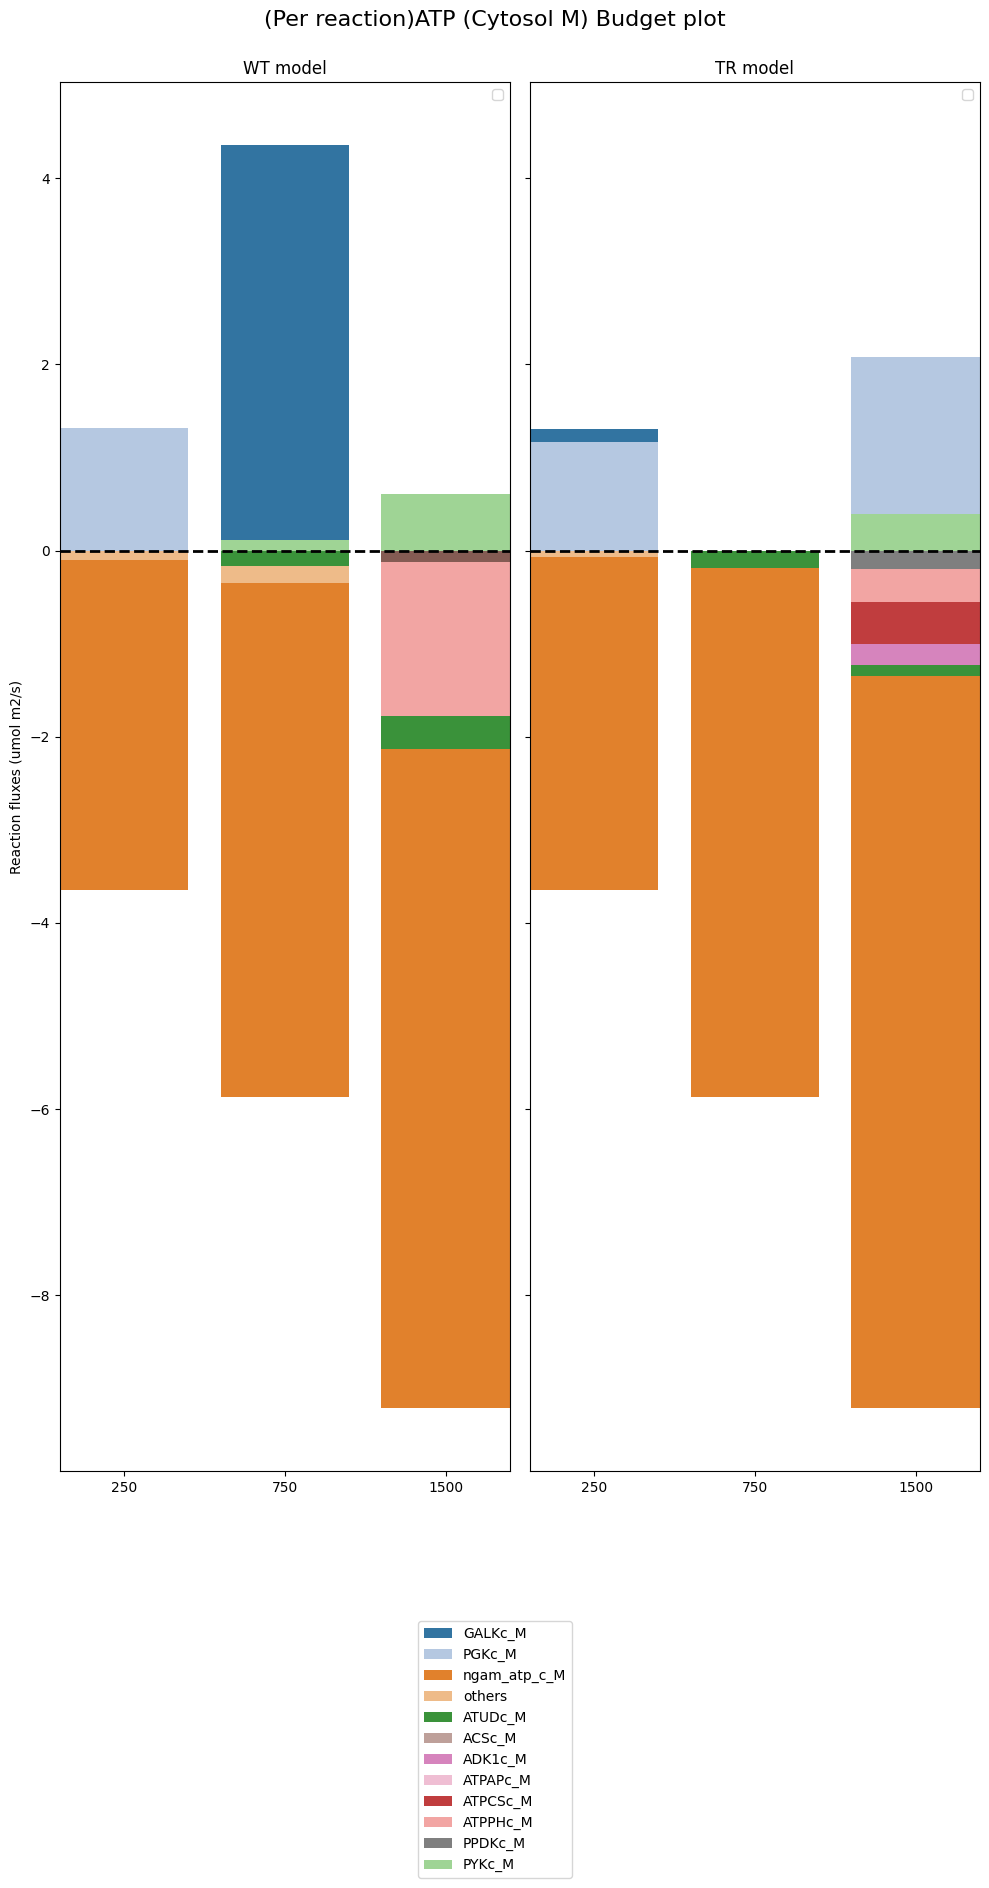

saved plot to ./plots/1510202/Budget_plotsATP (Stromal M).png


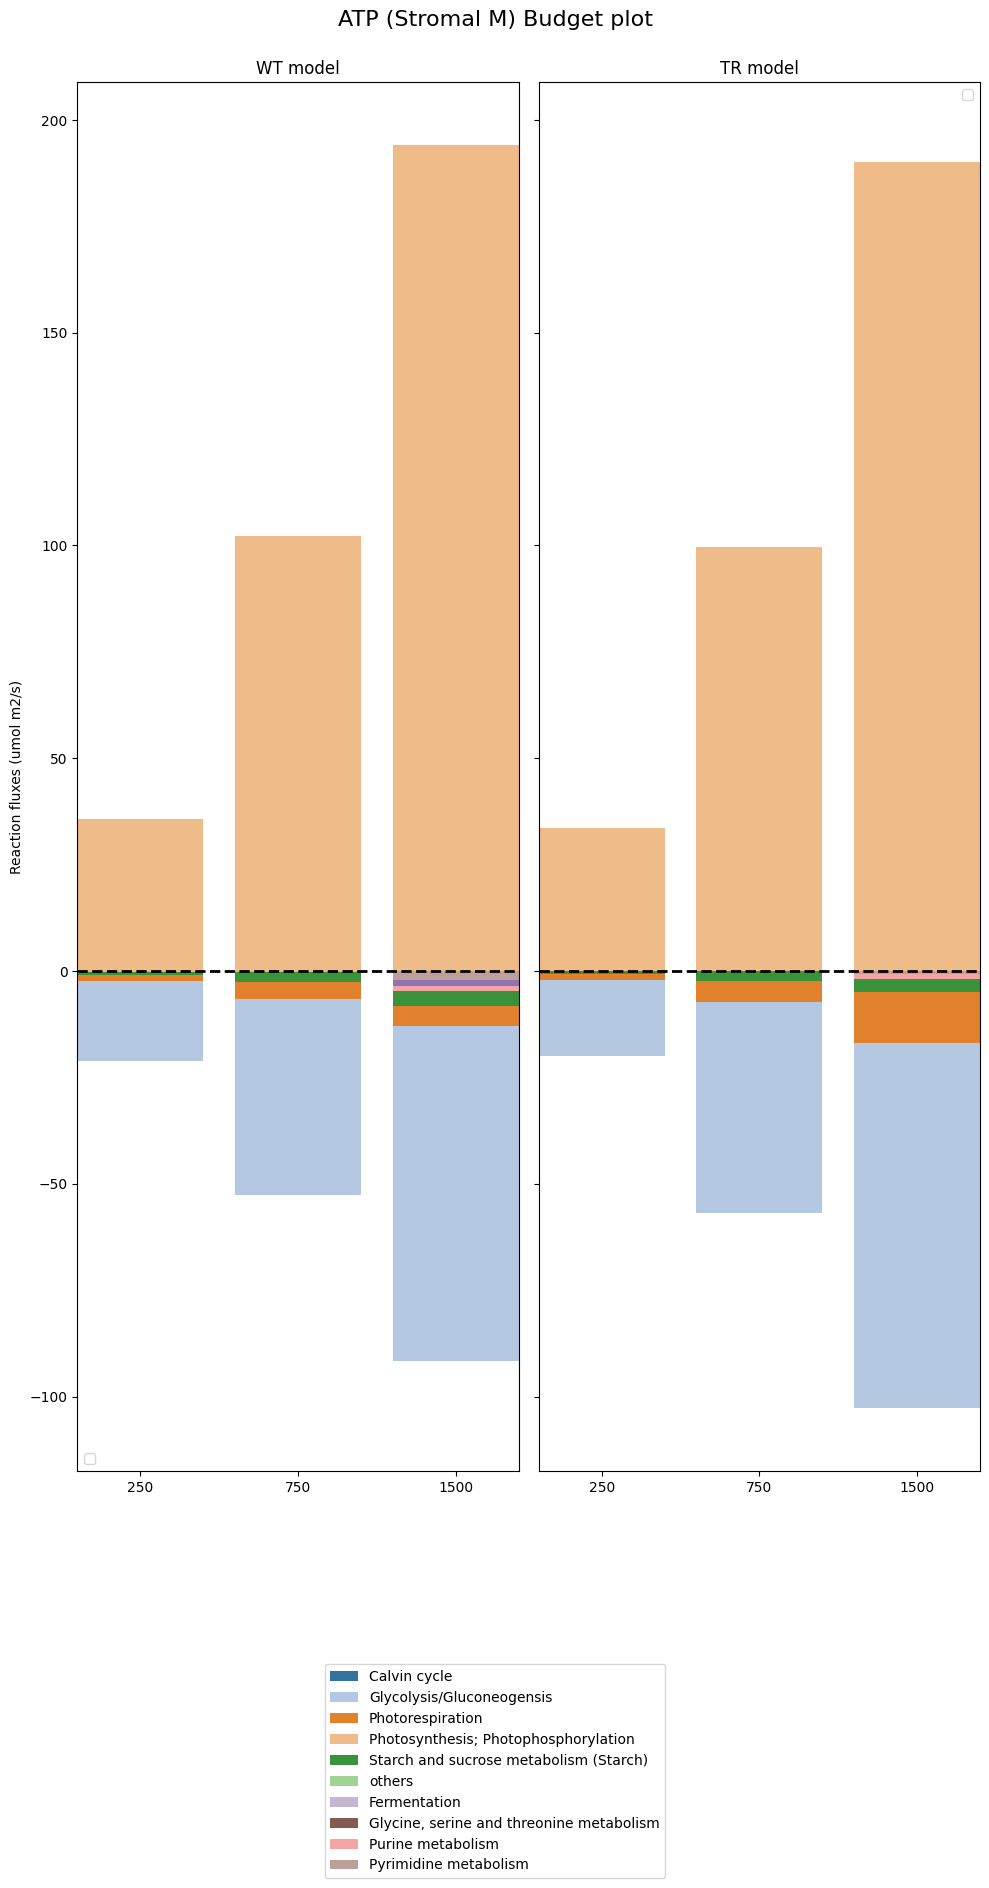

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)ATP (Stromal M).png


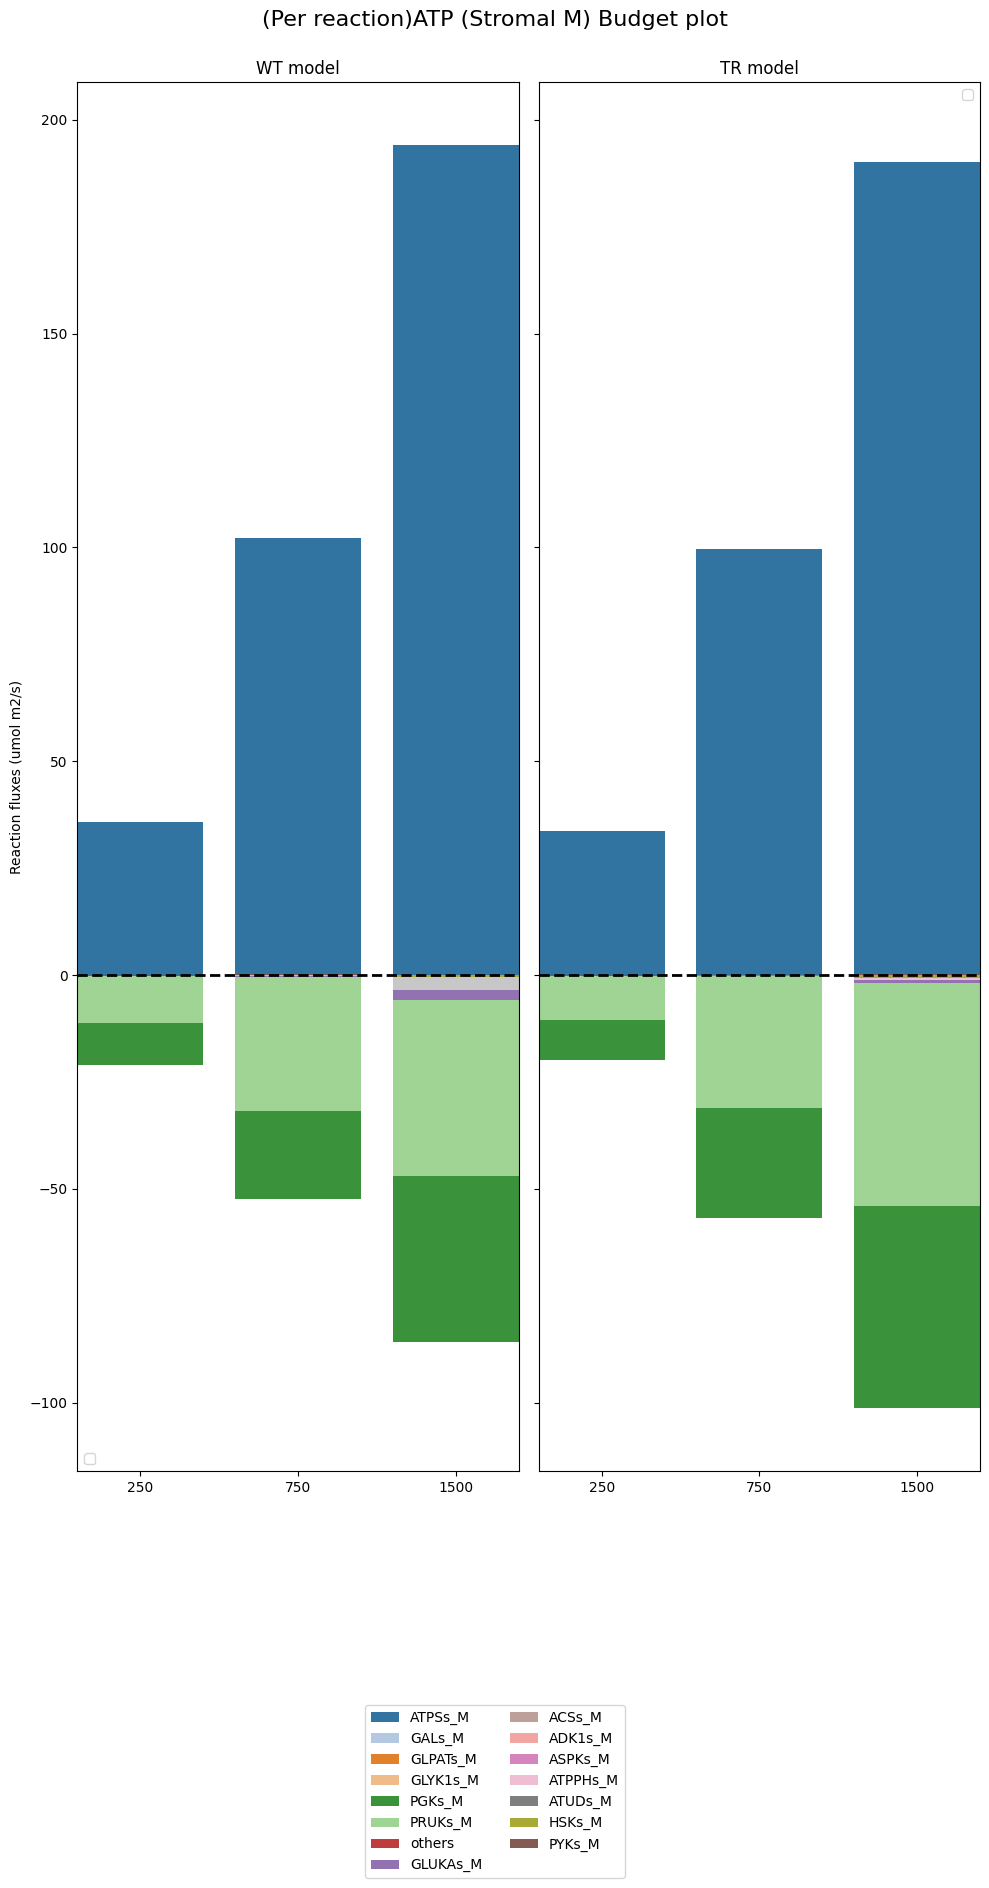

saved plot to ./plots/1510202/Budget_plotsNADH (Peroxisomal M cell).png


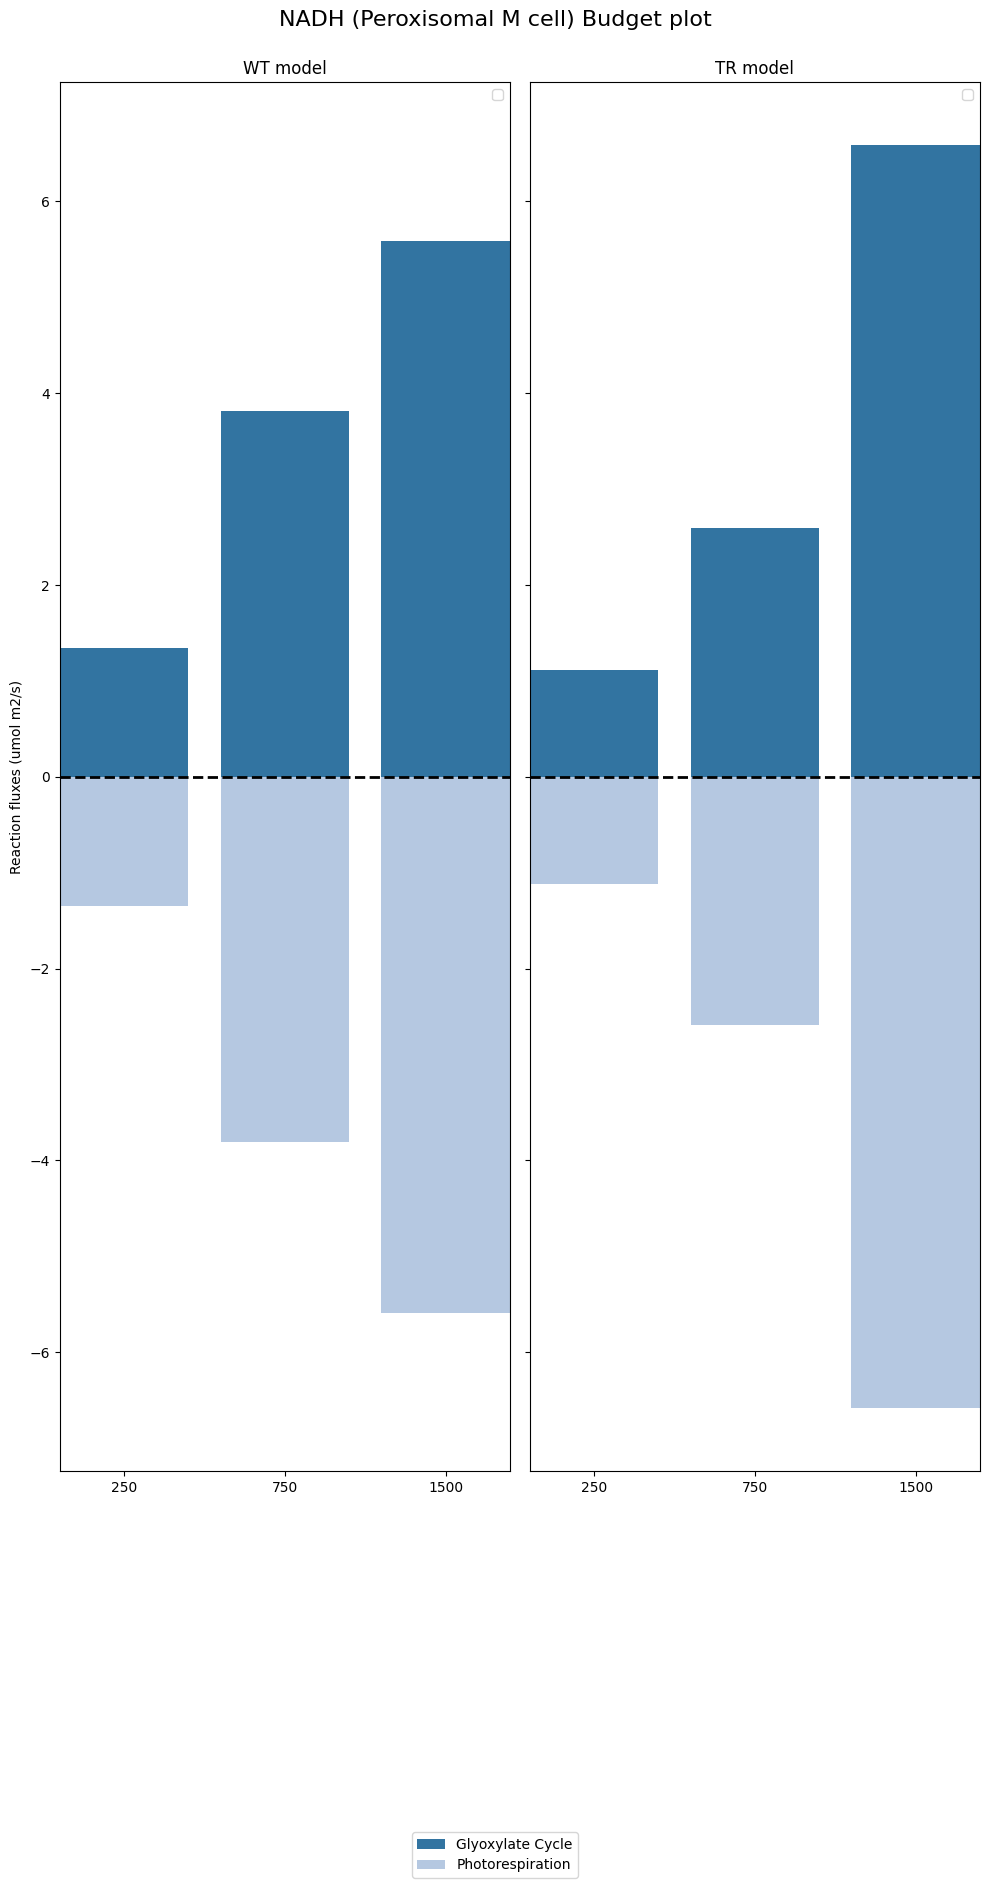

saved plot to ./plots/8th-Attempt-0810-2023-final/Budget_plots(Per reaction)NADH (Peroxisomal M cell).png


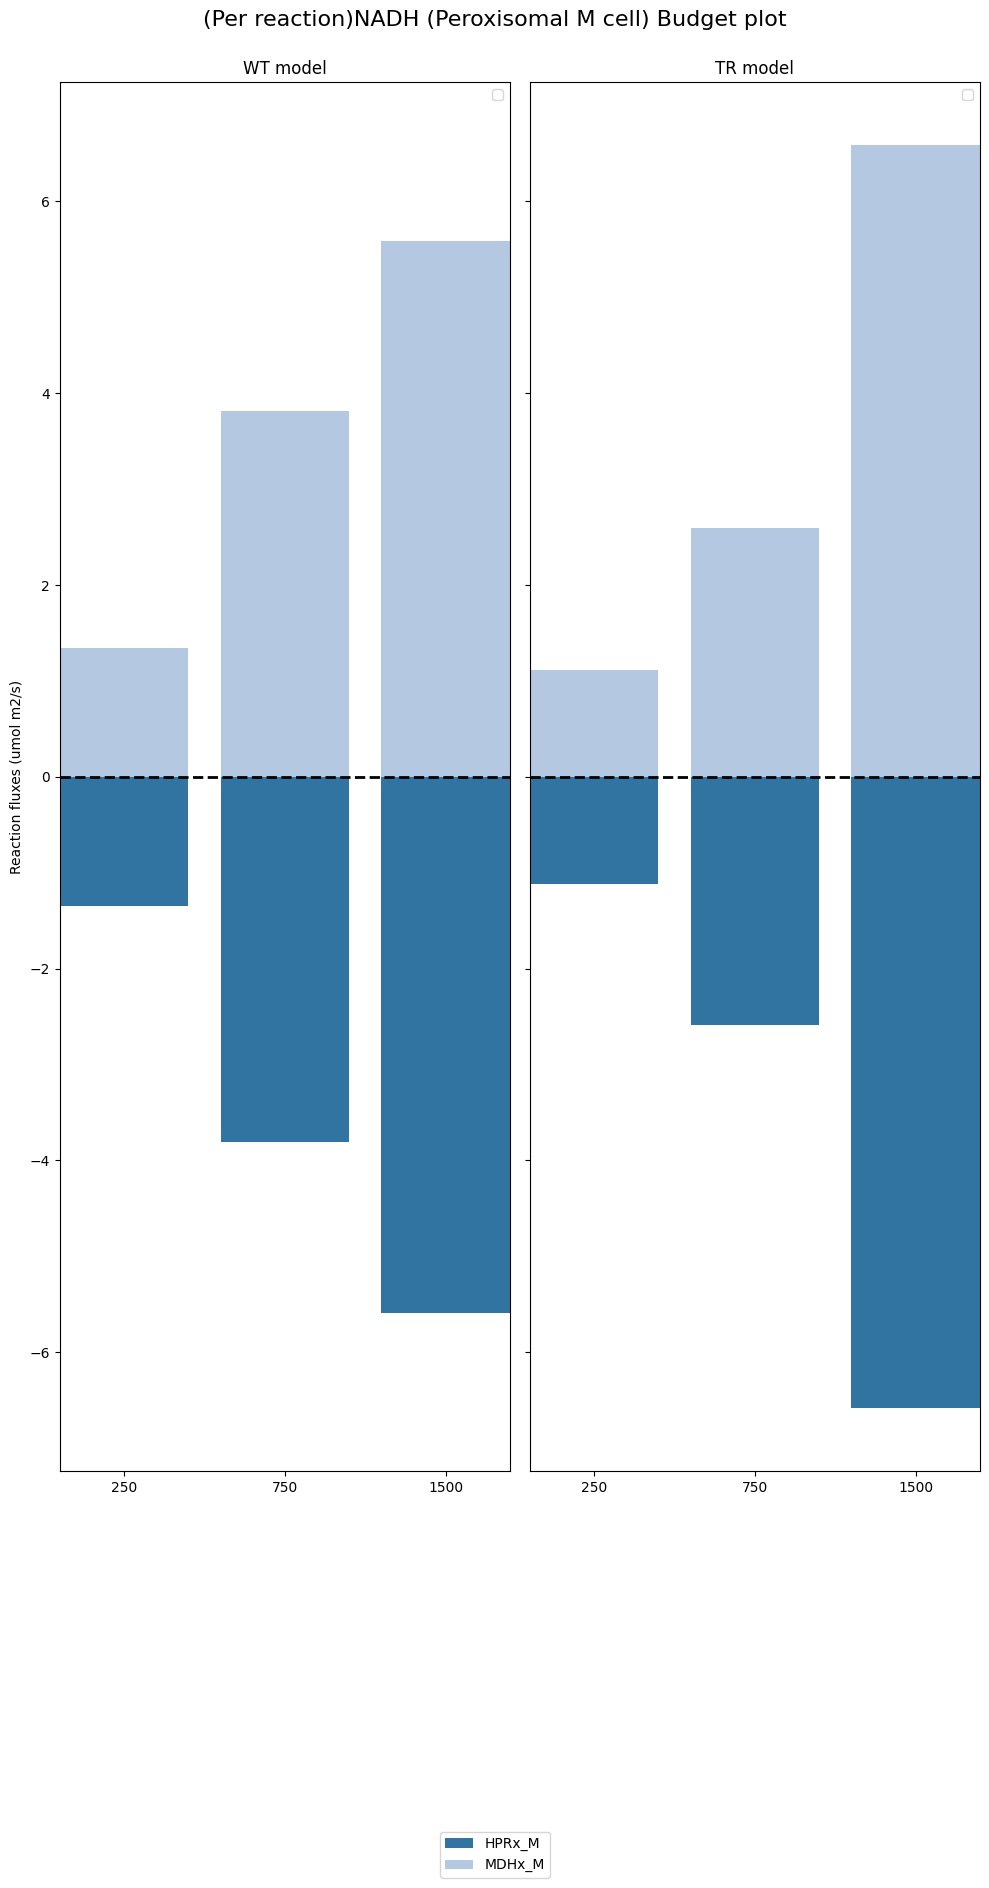

done


In [4]:
met_list = ['nadph_','atp_','nadh_','mal-L_','co2_','o2_', 'dhap_', 'h2o_', 'nh4_', 'nadph_s0', 'atp_c0', 'atp_s0', 'nadh_x0']
title_list = ['NADPH','ATP','NADH', 'L-malate', 'CO2', 'O2', 'DHAP', 'H2O', 'NH4', 'NADPH (Stromal M)', 'ATP (Cytosol M)', 'ATP (Stromal M)', 'NADH (Peroxisomal M cell)']

main_args = dict(zip(met_list, title_list))

def main(df_list,met_dict, model=trans_model,names=names, stratified='', filepath_for_tables = './flux_results/for_final_analysis/budget_tables'):
    
    #Create summary tables for later viewing
    filename1 = 'mets_budget_table_summaries'
    workbook1 = mm.create_xlsx(filename1, filepath_for_tables)
    
    filename2 = 'mets_budget_table_stratified'
    workbook2 = mm.create_xlsx(filename2, filepath_for_tables)
    
    #Generate main df
    df_all = merge_dataframes(df_list, names)
    
    
    for key, val in met_dict.items():

        rxn_list=get_aggregate_reactions_mets(model, [key])
        adj_df = calculate_adjusted_fluxes(df_all, rxn_list, sum_by_subsystem=True)
        generate_economy_plot(adj_df, title=val, directory='./plots/1510202/Budget_plots')

        #Generate stratified df for saving results
        rxn_budget_df = calculate_adjusted_fluxes(df_all, rxn_list, sum_by_subsystem=False)
        generate_economy_plot(rxn_budget_df, title=f'(Per reaction){val}', cmap='reaction_id', directory='./plots/8th-Attempt-0810-2023-final/Budget_plots')


        #Save the budget plots to excel
        adj_df.to_excel(workbook1, sheet_name=str(val))
        rxn_budget_df.to_excel(workbook2, sheet_name=str(val)) 

    workbook1.close()
    workbook2.close()
    print('done')
    
    
main(df_list, main_args)                                 

    

Notes;
Analysis shows most of the ATP consumption is correctly indicated (i.e. dedicated towards Calvin Cycle) as well as ATP production w/c is from Photosynthesis. Minor fluxes comes from Mitochondrial metabolism and glycolysis which partially support cytosolic ATP demand

I might be able to get "closer" results if I rescale the fluxes at the dataframe level rather than at the means level.

I rescaled it now. Let's see what it shows
